# Análise do Classificador LLM e conjunto de dados CohQuAD Init pt-br

Realiza a análise do classificador utilizando os LLMs, GPT-3.5, Gemini, LlaMa, Copilot e Sabiá-3.

Classes:
- 1 - Documento coerente
- 0 - Documento Incoerente
----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

**Artigo padding dinâmico:**
https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e

# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.
    """

    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))

    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.

      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.
    """

    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()

    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)

    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download
    nome_arquivo = nome_arquivo_destino.split("/")[-1]

    # Define o nome e caminho do arquivo temporário
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"

    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))

    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:
        tamanho_conteudo = data.headers.get("Content-Length")
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):
            if chunk:
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)

    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)

    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """

    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).

      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)

    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "

    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).

      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)

    sentencas = []
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())

    # Fecha o arquivo
    arquivo.close()

    return sentencas

In [7]:
def salvar(nome_arquivo,texto):
    """
      Salva um texto em arquivo.

      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))

    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))

Calcula a média de uma lista tempo string no formato hh:mm:ss.

In [9]:
# Import das bibliotecas.
from cmath import rect, phase
from math import radians, degrees

def mediaAngulo(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))

def mediaTempo(tempos):
    '''
    Calcula a média de uma lista de tempo string no formato hh:mm:ss
    '''
    t = (tempo.split(':') for tempo in tempos)
    # Converte para segundos
    segundos = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    # Verifica se deu algum dia
    dia = 24 * 60 * 60
    # Converte para angulos
    para_angulos = [s * 360. / dia for s in segundos]
    # Calcula a média dos angulos
    media_como_angulo = mediaAngulo(para_angulos)
    media_segundos = media_como_angulo * dia / 360.
    if media_segundos < 0:
        media_segundos += dia
    # Recupera as horas e os minutos
    h, m = divmod(media_segundos, 3600)
    # Recupera os minutos e os segundos
    m, s = divmod(m, 60)
    return '{:02d}:{:02d}:{:02d}'.format(int(h), int(m), int(s))

Calcula a soma de uma lista de tempo string no formato hh:mm:ss

In [10]:
def somaTempo(tempos):
    '''
    Calcula a soma de uma lista de tempo string no formato hh:mm:ss
    '''
    t = (tempo.split(':') for tempo in tempos)
    # Converte para segundos
    segundos = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    # Soma os segundos
    soma_segundos = sum([s * 1. for s in segundos])
    # Recupera as horas e os minutos
    h, m = divmod(soma_segundos, 3600)
    # Recupera os minutos e os segundos
    m, s = divmod(m, 60)
    return '{:02d}:{:02d}:{:02d}'.format(int(h), int(m), int(s))

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [11]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    )
    estrategia_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Classe(ModeloArgumentosClassificacao) de definição dos parâmetros do modelo para classificação

In [12]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosClassificacao:
    '''
    Classe(ModeloArgumentosClassificacao) de definição dos parâmetros do modelo BERT para a classificação de coerência.
    '''
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )
    num_labels: int = field(
        default=2,
        metadata={"help": "número de rótulos a serem classificados."},
    )
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    optimizer: str = field(
        default="AdamW",
        metadata={"help": "otimizador do modelo."},
    )
    use_wandb : bool = field(
        default=True,
        metadata={"help": "habilita o uso do wandb."},
    )
    salvar_modelo_wandb : bool = field(
        default=True,
        metadata={"help": "habilita o salvamento do modelo no wandb."},
    )
    salvar_modelo : bool = field(
        default=False,
        metadata={"help": "habilita o salvamento do modelo."},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={"help": "habilita o salvamento do resultado da avaliação."},
    )
    salvar_classificacao : bool = field(
        default=False,
        metadata={"help": "habilita o salvamento da classificação."},
    )
    usar_mcl_ajustado: bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos perturbados comparados com o seu original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de previsões de palavras recuperadas mais próximas da máscara."},
    )
    epoca: int = field(
        default="1",
        metadata={"help": "Época a ser avaliada."},
    )
    fold: int = field(
        default="1",
        metadata={"help": "Fold a ser avaliado."},
    )

Biblioteca de limpeza de tela


In [13]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [14]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [15]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [16]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [17]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.

    Retorno:
    `device` - Um device de GPU ou CPU.
    """

    # Se existe GPU disponível.
    if torch.cuda.is_available():

        # Diz ao PyTorch para usar GPU.
        device = torch.device("cuda")

        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")

    return device

In [18]:
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [19]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.
        `device` - Um device de GPU.

      Retorno:
        `model` - Um objeto model BERT conectado a GPU.
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()

    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [20]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [21]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Mounted at /content/drive


# 2 Parametrização

## Gerais

In [22]:
MELHOR_TOP_K_PREDICAO = 1
MELHOR_DOCUMENTOS_PERTURBADOS = 1

## Específicos

Parâmetros do modelo

In [23]:
# Definição dos parâmetros do Modelo
model_args = ModeloArgumentosMedida(
    max_seq_len = 512,
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",

    #pretrained_model_name_or_path = "bert-large-uncased",
    #pretrained_model_name_or_path = "bert-base-uncased"
    pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",

    #modelo_spacy = "en_core_web_lg",
    #modelo_spacy = "en_core_web_md",
    #modelo_spacy = "en_core_web_sm",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",

    versao_modelo_spacy = "3.2.0",
    do_lower_case = False,  # default True
    output_attentions = False,  # default False
    output_hidden_states = True, # default False
    use_wandb = False,
    salvar_medicao = False, #Salva o resultado da medição
    salvar_avaliacao = False, # Salva o resultado da avaliação das medições
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path.
    estrategia_medida = 0, # Atributo usado para os logs do wandb. 0 - MEAN estratégia média / 1 - MAX  estratégia maior
    filtro_palavra = 0, # Atributo usado para os logs do wandb. 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
)

## Nome do diretório dos arquivos de dados

In [24]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_INIT_PTBR"

## Define o caminho para os arquivos de dados

In [25]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 4 Resultado do Classificador Binário usando LLM

## 4.1 Carregamento dos arquivos de dados originais e perturbados

### 4.1.1 Especifica os nomes dos arquivos de dados



In [26]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 4.1.2 Cria o diretório local para receber os dados

In [27]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):
    # Cria o diretório
    os.makedirs(dirbase)
    logging.info("Diretório criado: {}".format(dirbase))
else:
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/COHQUAD_INIT_PTBR


### 4.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [28]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens
*   `-d` Diretório de destino


In [29]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 4.1.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [30]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))

INFO:root:TERMINADO ORIGINAIS: 20.


In [31]:
lista_documentos_originais.sample(5)

,id,sentencas,documento
13,14,['O que é uma pilha e como empilhar um element...,O que é uma pilha e como empilhar um elemento ...
8,9,['O que é uma pilha e como empilhar seu elemen...,O que é uma pilha e como empilhar seu elemento?
9,10,['O que é uma fila e como enfileirar seu eleme...,O que é uma fila e como enfileirar seu elemento?
15,16,['O que é uma fila e como enfileirar e desenfi...,O que é uma fila e como enfileirar e desenfile...
18,19,['Em uma pilha a operação de empilhar ocorre e...,Em uma pilha a operação de empilhar ocorre em ...


#### Corrigir os tipos de colunas dos dados originais

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.



In [32]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasOriginais(lista_documentos_originais):

  # Corrige os tipos dos dados
  tipos = {"id": str}
  lista_documentos_originais = lista_documentos_originais.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))

  return lista_documentos_originais

In [33]:
lista_documentos_originais = corrigirTipoDadosColunasOriginais(lista_documentos_originais)

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 20.


#### Criando dados indexados originais

In [34]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

,sentencas,documento
id,,
1,[Como enfileirar elementos em uma fila?],Como enfileirar elementos em uma fila?
2,[Como desenfileirar elementos em uma fila?],Como desenfileirar elementos em uma fila?
3,[Como empilhar elementos em uma pilha?],Como empilhar elementos em uma pilha?
4,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma p...
5,[Como empilhar elementos em uma estrutura de d...,Como empilhar elementos em uma estrutura de da...


#### Carrega o arquivo dos dados perturbados

In [35]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))

INFO:root:TERMINADO PERTURBADOS: 20.


AlgUns csv estão com os nomes das colunas errados

In [36]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [37]:
lista_documentos_perturbados.sample(5)

,id,perturbado,documento_perturbado,sentencas
12,13_pert_0,['O que é uma pilha e como enfileirar um eleme...,O que é uma pilha e como enfileirar um element...,[['O que é uma [MASK] e como enfileirar um ele...
17,18_pert_0,['Como são implementadas as operações de enfil...,Como são implementadas as operações de enfilei...,[['Como são implementadas as operações de enfi...
14,15_pert_0,['O que é uma fila e como empilhar e desempilh...,O que é uma fila e como empilhar e desempilhar...,[['O que é uma [MASK] e como empilhar e desemp...
7,8_pert_0,['Como desempilhar elementos em uma estrutura ...,Como desempilhar elementos em uma estrutura de...,[['Como desempilhar elementos em uma estrutura...
8,9_pert_0,['O que é uma fila e como empilhar seu element...,O que é uma fila e como empilhar seu elemento ?,[['O que é uma [MASK] e como empilhar seu elem...


#### Corrigir os tipos de colunas dos dados perturbados
Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.


In [38]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados):

  # Corrige os tipos dos dados
  tipos = {"id": str}
  lista_documentos_perturbados = lista_documentos_perturbados.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
  lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))

  return lista_documentos_perturbados

In [39]:
lista_documentos_perturbados = corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados)

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 20.


#### Criando dados indexados perturbados

In [40]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

,perturbado,documento_perturbado,sentencas
id,,,
1_pert_0,[Como enfileirar elementos em uma pilha ?],Como enfileirar elementos em uma pilha ?',"[[Como enfileirar elementos em uma [MASK] ?, f..."
2_pert_0,[Como desenfileirar elementos em uma pilha ?],Como desenfileirar elementos em uma pilha ?',[[Como desenfileirar elementos em uma [MASK] ?...
3_pert_0,[Como empilhar elementos em uma fila ?],Como empilhar elementos em uma fila ?,"[[Como empilhar elementos em uma [MASK] ?, pil..."
4_pert_0,[Como empilhar e desempilhar elementos em uma ...,Como empilhar e desempilhar elementos em uma f...,[[Como empilhar e desempilhar elementos em uma...
5_pert_0,[Como empilhar elementos em uma estrutura de d...,Como empilhar elementos em uma estrutura de da...,[[Como empilhar elementos em uma estrutura de ...


### 4.1.5 Agrupar os dados originais e perturbados

In [41]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado):

  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar:
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]
      #print("id_documento:",id_documento)

      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento))

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado
        #documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]

        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [42]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado)

Analisando documentos originais e perturbados
Processando 20 documentos originais


Documentos:   0%|          | 0/20 [00:00<?, ? documento/s]

<ipython-input-41-f133b4952199>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  id_documento = linha_documento[0]
<ipython-input-41-f133b4952199>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lista_sentenca_documento = linha_documento[1]
<ipython-input-41-f133b4952199>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
<ipython-in

In [43]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 40.


In [44]:
lista_documentos_agrupados.sample(5)

,id,sentencas,documento,classe
32,17,[Como são implementadas as operações de empilh...,Como são implementadas as operações de empilha...,1
16,9,[O que é uma pilha e como empilhar seu elemento?],O que é uma pilha e como empilhar seu elemento?,1
27,14_pert_0,[O que é uma fila e como empilhar um elemento ...,O que é uma fila e como empilhar um elemento n...,0
2,2,[Como desenfileirar elementos em uma fila?],Como desenfileirar elementos em uma fila?,1
38,20,[Em uma fila a operação de enfileirar ocorre e...,Em uma fila a operação de enfileirar ocorre em...,1


#### Criando dados indexados

In [45]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

,sentencas,documento,classe
id,,,
1,[Como enfileirar elementos em uma fila?],Como enfileirar elementos em uma fila?,1
1_pert_0,[Como enfileirar elementos em uma pilha ?],Como enfileirar elementos em uma pilha ?',0
2,[Como desenfileirar elementos em uma fila?],Como desenfileirar elementos em uma fila?,1
2_pert_0,[Como desenfileirar elementos em uma pilha ?],Como desenfileirar elementos em uma pilha ?',0
3,[Como empilhar elementos em uma pilha?],Como empilhar elementos em uma pilha?,1


## 4.2 Carrega os dados da classificação Llama3 70B

In [46]:
# Import das bibliotecas.
import pandas as pd
import io

def getDadosClassificacao():

  # Llama3 70B en
  dados = """id;classe;predicao
1;1;1
1_pert_0;0;0
2;1;1
2_pert_0;0;1
3;1;1
3_pert_0;0;1
4;1;1
4_pert_0;0;0
5;1;1
5_pert_0;0;0
6;1;1
6_pert_0;0;0
7;1;1
7_pert_0;0;0
8;1;1
8_pert_0;0;0
9;1;1
9_pert_0;0;0
10;1;1
10_pert_0;0;1
11;1;1
11_pert_0;0;0
12;1;1
12_pert_0;0;0
13;1;1
13_pert_0;0;0
14;1;1
14_pert_0;0;0
15;1;1
15_pert_0;0;1
16;1;1
16_pert_0;0;0
17;1;1
17_pert_0;0;0
18;1;1
18_pert_0;0;0
19;1;1
19_pert_0;0;0
20;1;1
20_pert_0;0;0"""

  # Lê a string como um DataFrame
  df_dados_classificacao = pd.read_csv(io.StringIO(dados), sep=";")

    # Corrige os tipos dos dados
  tipos = {"id": str}
  df_dados_classificacao = df_dados_classificacao.astype(tipos)

  print('Registros:', len(df_dados_classificacao))

  return df_dados_classificacao

In [47]:
# Recupera os dados da melhor classificação
df_dados_classificacao = getDadosClassificacao()

# Exibe o DataFrame
print(df_dados_classificacao)

Registros: 40
           id  classe  predicao
0           1       1         1
1    1_pert_0       0         0
2           2       1         1
3    2_pert_0       0         1
4           3       1         1
5    3_pert_0       0         1
6           4       1         1
7    4_pert_0       0         0
8           5       1         1
9    5_pert_0       0         0
10          6       1         1
11   6_pert_0       0         0
12          7       1         1
13   7_pert_0       0         0
14          8       1         1
15   8_pert_0       0         0
16          9       1         1
17   9_pert_0       0         0
18         10       1         1
19  10_pert_0       0         1
20         11       1         1
21  11_pert_0       0         0
22         12       1         1
23  12_pert_0       0         0
24         13       1         1
25  13_pert_0       0         0
26         14       1         1
27  14_pert_0       0         0
28         15       1         1
29  15_pert_0       0     

In [48]:
df_dados_classificacao.sample(5)

,id,classe,predicao
26,14,1,1
18,10,1,1
38,20,1,1
27,14_pert_0,0,0
17,9_pert_0,0,0


### Acurácia

In [49]:
def calculoClassificacao(df_dados_classificacao):
  vp_s = 0
  vn_s = 0
  fp_s = 0
  fn_s = 0
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    if linha['classe'] == 1 and linha['predicao'] == 1:
        vp_s = vp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 0:
        vn_s = vn_s + 1
    if linha['classe'] == 1 and linha['predicao'] == 0:
        fp_s = fp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 1:
        fn_s = fn_s + 1

  # Acurácia indica uma performance geral do modelo.
  # Dentre todas as classificações, quantas o modelo classificou corretamente(vp=1 e vn=0).
  if (vp_s+vn_s+fp_s+fn_s) != 0:
    acc = (vp_s+vn_s)/(vp_s+vn_s+fp_s+fn_s)
  else:
    acc  = 0

  # Recall(Revocação) avalia todas as situações da classe Positivo(vp=1) com o valor esperado e quantas estão corretas.
  if (vp_s+fn_s) != 0:
      rec = (vp_s)/(vp_s+fn_s)
  else:
      rec = 0

  # Precisão avalia as classificações da classe positivo(vp=1 e fp=0) que o modelo fez e quantas estão corretas.
  if (vp_s+fp_s) != 0:
      pre = (vp_s)/(vp_s+fp_s)
  else:
      pre = 0

  # F1 é a média harmônica entre precisão e recall.
  if (pre + rec) != 0:
    f1 = 2 * ((pre * rec)/(pre + rec))
  else:
    f1 = 0

  return acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s

In [50]:
acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s = calculoClassificacao(df_dados_classificacao)

print("Acurácia: {0:.2%}".format(acc))
print("Recall  : {0:.2%}".format(rec))
print("Precisão: {0:.2%}".format(pre))
print("F1      : {0:.2%}".format(f1))

total = vp_s + vn_s + fp_s + fn_s
print("Total   :", total)
print("vp      : {0:.2%} de {1:1d}".format((vp_s/total), vp_s))
print("vn      : {0:.2%} de {1:1d}".format((vn_s/total), vn_s))
print("fp      : {0:.2%} de {1:1d}".format((fp_s/total), fp_s))
print("fn      : {0:.2%} de {1:1d}".format((fn_s/total), fn_s))

Acurácia: 90.00%
Recall  : 83.33%
Precisão: 100.00%
F1      : 90.91%
Total   : 40
vp      : 50.00% de 20
vn      : 40.00% de 16
fp      : 0.00% de 0
fn      : 10.00% de 4


#### Matriz de confusão

In [51]:
# Import das bibliotecas.
import matplotlib
import matplotlib.pyplot as plt

TAMANHO_FONTE = 38
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE+2)   # Tamanho da fonte do título da figura

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       0.83      1.00      0.91        20

    accuracy                           0.90        40
   macro avg       0.92      0.90      0.90        40
weighted avg       0.92      0.90      0.90        40



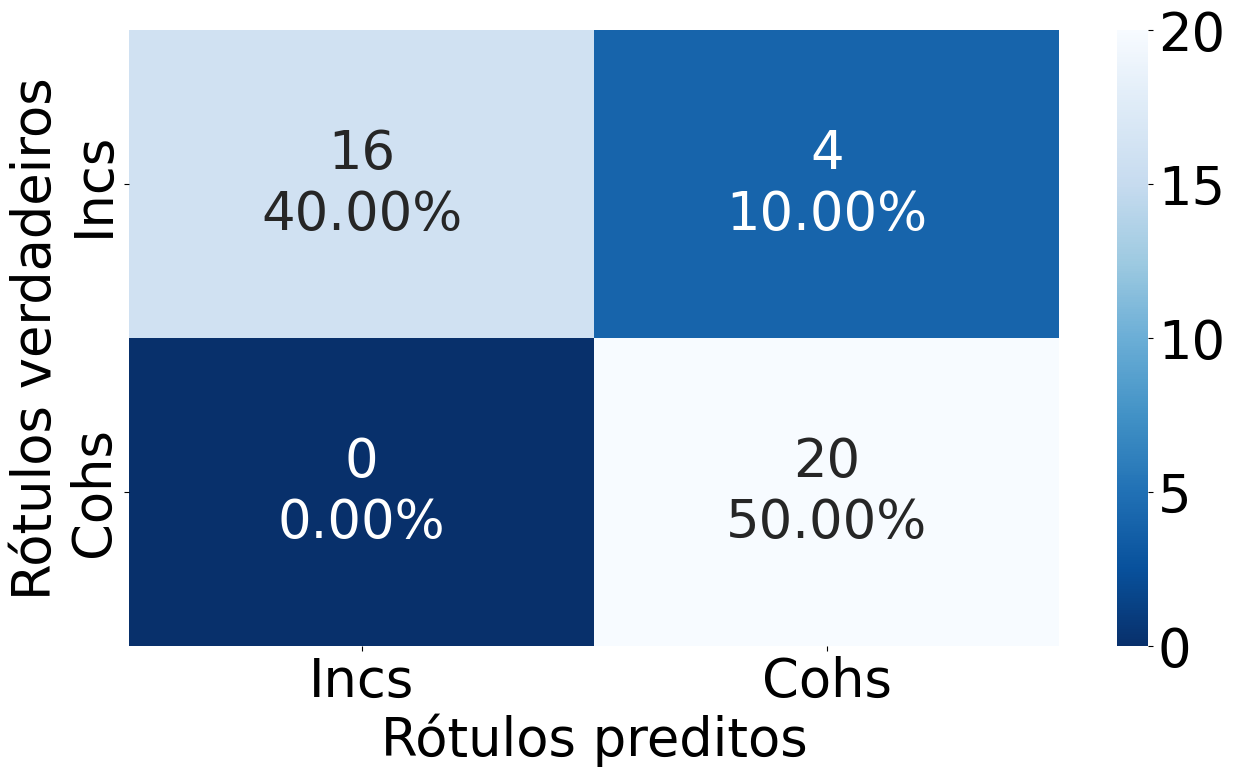

In [52]:
# Import das bibliotecas.
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

x_alvo =     df_dados_classificacao['classe'].tolist()
y_predicao = df_dados_classificacao['predicao'].tolist()

print(classification_report(x_alvo, y_predicao))

# Insere os dados no gráfico
cf_matrix = confusion_matrix(x_alvo, y_predicao)
quantidade_grupos = ["{0:0.0f}".format(valor) for valor in cf_matrix.flatten()]
percentual_grupos = ["{0:.2%}".format(valor) for valor in cf_matrix.flatten()/np.sum(cf_matrix)]
rotulos = [f"{v1}\n{v2}" for v1, v2 in zip(quantidade_grupos,percentual_grupos)]
rotulos = np.asarray(rotulos).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=rotulos, fmt='', cmap='Blues_r')

# Texto do eixo x
ax.set_xlabel('Rótulos preditos')
# Texto do eixo y
ax.set_ylabel('Rótulos verdadeiros')
# Rótulos adicionais
ax.xaxis.set_ticklabels(['Incs','Cohs'])
ax.yaxis.set_ticklabels(['Incs','Cohs'])

# Mostra o gráfico
plt.show()

### Listas em pares

#### Listas de pares de documentos originais e perturbados classificados corretamente

In [53]:
def listaClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
    # 0 - Documento perturbado
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])

  tipos = {"id": str}
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"])
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [54]:
lista_retorno_classificado_corretamente, lista_retorno_DO_correto, lista_retorno_pertDO_correto = listaClassificadoCorretamente(df_dados_classificacao)
print('Cohs e Incs classificados corretamente:', len(lista_retorno_classificado_corretamente))
print('Cohs classificados corretamente(VP)     :', len(lista_retorno_DO_correto))
print('Incs classificados corretamente(FP) :', len(lista_retorno_pertDO_correto))

Cohs e Incs classificados corretamente: 36
Cohs classificados corretamente(VP)     : 20
Incs classificados corretamente(FP) : 16


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [55]:
def listaClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
    # 0 - Documento Perturbado
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])

  tipos = {"id": str}
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"])
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [56]:
lista_retorno_classificado_incorretamente, lista_retorno_DO_incorreto, lista_retorno_pertDO_incorreto = listaClassificadoIncorretamente(df_dados_classificacao)
print('DO e pertDO classificados incorretamente:', len(lista_retorno_classificado_incorretamente))
print('DO classificados incorretamente(VN)     :', len(lista_retorno_DO_incorreto))
print('pertDO classificados incorretamente(FN) :', len(lista_retorno_pertDO_incorreto))

DO e pertDO classificados incorretamente: 4
DO classificados incorretamente(VN)     : 0
pertDO classificados incorretamente(FN) : 4


#### Acurácia das listas

In [57]:
total = len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente)
print("Total de documentos                 :", total)
print("  Total de documentos originais     :", (len(lista_retorno_DO_correto)+len(lista_retorno_DO_incorreto)))
print("  Total de documentos perturbados   :", (len(lista_retorno_pertDO_correto)+len(lista_retorno_pertDO_incorreto)))
print("Total de acertos                    :", len(lista_retorno_classificado_corretamente))
print("Total de erros                      :", len(lista_retorno_classificado_incorretamente))
print()
print("Acurácia                                        : {0:.2%}".format(len(lista_retorno_classificado_corretamente)/total))
print("  Cohs coerentes       = Verdadeiros positivos(VP): {0:.2%}".format(len(lista_retorno_DO_correto)/total))
print("  Incs incoerentes     = Falsos positivos(FP)     : {0:.2%}".format(len(lista_retorno_pertDO_correto)/total))
print("  Cohs incoerentes     = Verdadeiro negativos(VN) : {0:.2%}".format(len(lista_retorno_DO_incorreto)/total))
print("  Incs coerentes       = Falsos negativos(FN)     : {0:.2%}".format(len(lista_retorno_pertDO_incorreto)/total))

Total de documentos                 : 40
  Total de documentos originais     : 20
  Total de documentos perturbados   : 20
Total de acertos                    : 36
Total de erros                      : 4

Acurácia                                        : 90.00%
  Cohs coerentes       = Verdadeiros positivos(VP): 50.00%
  Incs incoerentes     = Falsos positivos(FP)     : 40.00%
  Cohs incoerentes     = Verdadeiro negativos(VN) : 0.00%
  Incs coerentes       = Falsos negativos(FN)     : 10.00%


#### Listas documentos originais e perturbados e suas classificações sem repetições

Remove a duplicidade dos documentos originais classificados corretamente(VP)

In [58]:
print("Com repetição:",len(lista_retorno_DO_correto))
lista_retorno_DO_classificado_corretamente_sem_repeticao = lista_retorno_DO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_corretamente_sem_repeticao))

Com repetição: 20
Sem repetição: 20


Criando dados indexados

In [59]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1


Remove a duplicidade dos documentos originais classificados incorretamente(VN)

In [60]:
print("Com repetição:",len(lista_retorno_DO_incorreto))
lista_retorno_DO_classificado_incorretamente_sem_repeticao = lista_retorno_DO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_incorretamente_sem_repeticao))

Com repetição: 0
Sem repetição: 0


Criando dados indexados

In [61]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,


Remove a duplicidade dos documentos perturbados classificados corretamente(FP)

In [62]:
print("Com repetição:",len(lista_retorno_pertDO_correto))
lista_retorno_pertDO_classificado_corretamente_sem_repeticao = lista_retorno_pertDO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_corretamente_sem_repeticao))

Com repetição: 16
Sem repetição: 16


Criando dados indexados

In [63]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1_pert_0,0,0
4_pert_0,0,0
5_pert_0,0,0
6_pert_0,0,0
7_pert_0,0,0


Remove a duplicidade dos documentos perturbados classificados incorretamente(FN)

In [64]:
print("Com repetição:",len(lista_retorno_pertDO_incorreto))
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao = lista_retorno_pertDO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_incorretamente_sem_repeticao))

Com repetição: 4
Sem repetição: 4


Criando dados indexados

In [65]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
2_pert_0,0,1
3_pert_0,0,1
10_pert_0,0,1
15_pert_0,0,1


Remove as duplicidades dos documentos classificados corretamente.

In [66]:
print("Com repetição:",len(lista_retorno_classificado_corretamente))
lista_retorno_classificado_corretamente_sem_repeticao = lista_retorno_classificado_corretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_corretamente_sem_repeticao))

Com repetição: 36
Sem repetição: 36


Criando dados indexados

In [67]:
lista_retorno_classificado_corretamente_sem_repeticao.sample(5)

,id,classe,predicao
15,9_pert_0,0,0
7,5_pert_0,0,0
30,18,1,1
28,17,1,1
35,20_pert_0,0,0


In [68]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_corretamente_sem_repeticao_indexado = lista_retorno_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1,1,1
1_pert_0,0,0
2,1,1
3,1,1
4,1,1


Remove as duplicidades dos documentos perturbados classificados incorretamente.

In [69]:
print("Com repetição:",len(lista_retorno_classificado_incorretamente))
lista_retorno_classificado_incorretamente_sem_repeticao = lista_retorno_classificado_incorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_incorretamente_sem_repeticao))

Com repetição: 4
Sem repetição: 4


Criando dados indexados

In [70]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
2_pert_0,0,1
3_pert_0,0,1
10_pert_0,0,1
15_pert_0,0,1


### Listas

#### Lista de documentos originais(1) classificados corretamente(1)

In [71]:
def listaOriginalClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [72]:
lista_documento_original_classificado_corretamente = listaOriginalClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_original_classificado_corretamente:', len(lista_documento_original_classificado_corretamente))

lista_documento_original_classificado_corretamente: 20


In [73]:
print("Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1):", len(lista_documento_original_classificado_corretamente))
for i, linha in lista_documento_original_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1): 20
   0 - Como enfileirar elementos em uma fila? 1
   1 - Como desenfileirar elementos em uma fila? 1
   2 - Como empilhar elementos em uma pilha? 1
   3 - Como empilhar e desempilhar elementos em uma pilha? 1
   4 - Como empilhar elementos em uma estrutura de dados pilha? 1
   5 - Como empilhar e desempilhar elementos em uma estrutura de dados pilha? 1
   6 - Como desempilhar elementos em uma pilha? 1
   7 - Como desempilhar elementos em uma estrutura de dados pilha? 1
   8 - O que é uma pilha e como empilhar seu elemento? 1
   9 - O que é uma fila e como enfileirar seu elemento? 1
   10 - O que é uma fila e como desenfileirar um elemento nela? 1
   11 - O que é uma pilha e como desempilhar um elemento nela? 1
   12 - O que é uma fila e como enfileirar um elemento nela? 1
   13 - O que é uma pilha e como empilhar um elemento nela? 1
   14 - O que é uma pilha e como empilhar e desempilhar seus e

#### Lista de documento originais(1) classificados incorretamente(0)

In [74]:
def listaOriginalClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [75]:
lista_documento_original_classificado_incorretamente = listaOriginalClassificadoIncorretamente(df_dados_classificacao)

print("Lista de documentos originais classificados incorretamente:",len(lista_documento_original_classificado_incorretamente))

Lista de documentos originais classificados incorretamente: 0


In [76]:
print("Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0):", len(lista_documento_original_classificado_incorretamente))
for i, documento in lista_documento_original_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0): 0


#### Lista Documentos Perturbados(0) Classificados corretamente(0)

In [77]:
def listaPerturbadoClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [78]:
lista_documento_perturbado_classificado_corretamente = listaPerturbadoClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_corretamente:', len(lista_documento_perturbado_classificado_corretamente))

lista_documento_perturbado_classificado_corretamente: 16


In [79]:
print("Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0):", len(lista_documento_perturbado_classificado_corretamente))
for i, documento in lista_documento_perturbado_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0): 16
   0 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   1 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   2 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   3 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   4 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   5 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   6 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   7 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   8 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   9 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   10 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   11 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   12 - Em 

#### Lista Documentos Perturbados(0) Classificados incorretamente(1)

In [80]:
def listaPerturbadoClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [81]:
lista_documento_perturbado_classificado_incorretamente = listaPerturbadoClassificadoIncorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_incorretamente:', len(lista_documento_perturbado_classificado_incorretamente))

lista_documento_perturbado_classificado_incorretamente: 4


In [82]:
print("Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1):", len(lista_documento_perturbado_classificado_incorretamente))
for i, documento in lista_documento_perturbado_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1): 4
   0 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   1 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   2 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   3 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1


## 4.3 Carrega os dados da classificação ChatGPT 3.5

In [83]:
# Import das bibliotecas.
import pandas as pd
import io

def getDadosClassificacao():

  # Llama3 70B en
  dados = """id;classe;predicao
1;1;1
1_pert_0;0;0
2;1;1
2_pert_0;0;0
3;1;1
3_pert_0;0;0
4;1;1
4_pert_0;0;1
5;1;1
5_pert_0;0;0
6;1;1
6_pert_0;0;1
7;1;1
7_pert_0;0;0
8;1;1
8_pert_0;0;0
9;1;1
9_pert_0;0;0
10;1;1
10_pert_0;0;0
11;1;1
11_pert_0;0;0
12;1;1
12_pert_0;0;0
13;1;1
13_pert_0;0;0
14;1;1
14_pert_0;0;0
15;1;1
15_pert_0;0;0
16;1;1
16_pert_0;0;0
17;1;1
17_pert_0;0;1
18;1;1
18_pert_0;0;0
19;1;1
19_pert_0;0;0
20;1;1
20_pert_0;0;0"""

  # Lê a string como um DataFrame
  df_dados_classificacao = pd.read_csv(io.StringIO(dados), sep=";")

    # Corrige os tipos dos dados
  tipos = {"id": str}
  df_dados_classificacao = df_dados_classificacao.astype(tipos)

  print('Registros:', len(df_dados_classificacao))

  return df_dados_classificacao

In [84]:
# Recupera os dados da melhor classificação
df_dados_classificacao = getDadosClassificacao()

# Exibe o DataFrame
print(df_dados_classificacao)

Registros: 40
           id  classe  predicao
0           1       1         1
1    1_pert_0       0         0
2           2       1         1
3    2_pert_0       0         0
4           3       1         1
5    3_pert_0       0         0
6           4       1         1
7    4_pert_0       0         1
8           5       1         1
9    5_pert_0       0         0
10          6       1         1
11   6_pert_0       0         1
12          7       1         1
13   7_pert_0       0         0
14          8       1         1
15   8_pert_0       0         0
16          9       1         1
17   9_pert_0       0         0
18         10       1         1
19  10_pert_0       0         0
20         11       1         1
21  11_pert_0       0         0
22         12       1         1
23  12_pert_0       0         0
24         13       1         1
25  13_pert_0       0         0
26         14       1         1
27  14_pert_0       0         0
28         15       1         1
29  15_pert_0       0     

In [85]:
df_dados_classificacao.sample(5)

,id,classe,predicao
12,7,1,1
7,4_pert_0,0,1
2,2,1,1
37,19_pert_0,0,0
20,11,1,1


### Acurácia

In [86]:
def calculoClassificacao(df_dados_classificacao):
  vp_s = 0
  vn_s = 0
  fp_s = 0
  fn_s = 0
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    if linha['classe'] == 1 and linha['predicao'] == 1:
        vp_s = vp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 0:
        vn_s = vn_s + 1
    if linha['classe'] == 1 and linha['predicao'] == 0:
        fp_s = fp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 1:
        fn_s = fn_s + 1

  # Acurácia indica uma performance geral do modelo.
  # Dentre todas as classificações, quantas o modelo classificou corretamente(vp=1 e vn=0).
  if (vp_s+vn_s+fp_s+fn_s) != 0:
    acc = (vp_s+vn_s)/(vp_s+vn_s+fp_s+fn_s)
  else:
    acc  = 0

  # Recall(Revocação) avalia todas as situações da classe Positivo(vp=1) com o valor esperado e quantas estão corretas.
  if (vp_s+fn_s) != 0:
      rec = (vp_s)/(vp_s+fn_s)
  else:
      rec = 0

  # Precisão avalia as classificações da classe positivo(vp=1 e fp=0) que o modelo fez e quantas estão corretas.
  if (vp_s+fp_s) != 0:
      pre = (vp_s)/(vp_s+fp_s)
  else:
      pre = 0

  # F1 é a média harmônica entre precisão e recall.
  if (pre + rec) != 0:
    f1 = 2 * ((pre * rec)/(pre + rec))
  else:
    f1 = 0

  return acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s

In [87]:
acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s = calculoClassificacao(df_dados_classificacao)

print("Acurácia: {0:.2%}".format(acc))
print("Recall  : {0:.2%}".format(rec))
print("Precisão: {0:.2%}".format(pre))
print("F1      : {0:.2%}".format(f1))

total = vp_s + vn_s + fp_s + fn_s
print("Total   :", total)
print("vp      : {0:.2%} de {1:1d}".format((vp_s/total), vp_s))
print("vn      : {0:.2%} de {1:1d}".format((vn_s/total), vn_s))
print("fp      : {0:.2%} de {1:1d}".format((fp_s/total), fp_s))
print("fn      : {0:.2%} de {1:1d}".format((fn_s/total), fn_s))

Acurácia: 92.50%
Recall  : 86.96%
Precisão: 100.00%
F1      : 93.02%
Total   : 40
vp      : 50.00% de 20
vn      : 42.50% de 17
fp      : 0.00% de 0
fn      : 7.50% de 3


#### Matriz de confusão

In [88]:
# Import das bibliotecas.
import matplotlib
import matplotlib.pyplot as plt

TAMANHO_FONTE = 38
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE+2)   # Tamanho da fonte do título da figura

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.87      1.00      0.93        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



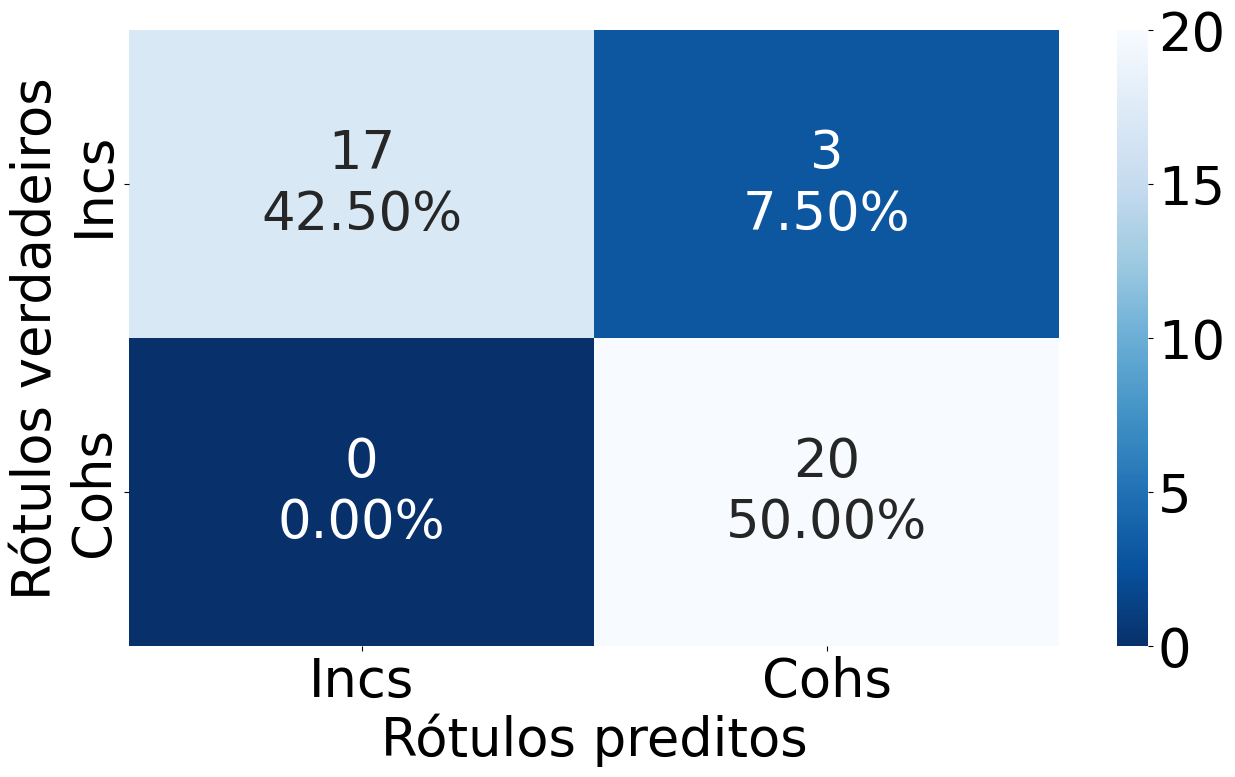

In [89]:
# Import das bibliotecas.
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

x_alvo =     df_dados_classificacao['classe'].tolist()
y_predicao = df_dados_classificacao['predicao'].tolist()

print(classification_report(x_alvo, y_predicao))

# Insere os dados no gráfico
cf_matrix = confusion_matrix(x_alvo, y_predicao)
quantidade_grupos = ["{0:0.0f}".format(valor) for valor in cf_matrix.flatten()]
percentual_grupos = ["{0:.2%}".format(valor) for valor in cf_matrix.flatten()/np.sum(cf_matrix)]
rotulos = [f"{v1}\n{v2}" for v1, v2 in zip(quantidade_grupos,percentual_grupos)]
rotulos = np.asarray(rotulos).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=rotulos, fmt='', cmap='Blues_r')

# Texto do eixo x
ax.set_xlabel('Rótulos preditos')
# Texto do eixo y
ax.set_ylabel('Rótulos verdadeiros')
# Rótulos adicionais
ax.xaxis.set_ticklabels(['Incs','Cohs'])
ax.yaxis.set_ticklabels(['Incs','Cohs'])

# Mostra o gráfico
plt.show()

### Listas em pares

#### Listas de pares de documentos originais e perturbados classificados corretamente

In [90]:
def listaClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
    # 0 - Documento perturbado
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])

  tipos = {"id": str}
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"])
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [91]:
lista_retorno_classificado_corretamente, lista_retorno_DO_correto, lista_retorno_pertDO_correto = listaClassificadoCorretamente(df_dados_classificacao)
print('Cohs e Incs classificados corretamente:', len(lista_retorno_classificado_corretamente))
print('Cohs classificados corretamente(VP)     :', len(lista_retorno_DO_correto))
print('Incs classificados corretamente(FP) :', len(lista_retorno_pertDO_correto))

Cohs e Incs classificados corretamente: 37
Cohs classificados corretamente(VP)     : 20
Incs classificados corretamente(FP) : 17


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [92]:
def listaClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
    # 0 - Documento Perturbado
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])

  tipos = {"id": str}
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"])
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [93]:
lista_retorno_classificado_incorretamente, lista_retorno_DO_incorreto, lista_retorno_pertDO_incorreto = listaClassificadoIncorretamente(df_dados_classificacao)
print('DO e pertDO classificados incorretamente:', len(lista_retorno_classificado_incorretamente))
print('DO classificados incorretamente(VN)     :', len(lista_retorno_DO_incorreto))
print('pertDO classificados incorretamente(FN) :', len(lista_retorno_pertDO_incorreto))

DO e pertDO classificados incorretamente: 3
DO classificados incorretamente(VN)     : 0
pertDO classificados incorretamente(FN) : 3


#### Acurácia das listas

In [94]:
total = len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente)
print("Total de documentos                 :", total)
print("  Total de documentos originais     :", (len(lista_retorno_DO_correto)+len(lista_retorno_DO_incorreto)))
print("  Total de documentos perturbados   :", (len(lista_retorno_pertDO_correto)+len(lista_retorno_pertDO_incorreto)))
print("Total de acertos                    :", len(lista_retorno_classificado_corretamente))
print("Total de erros                      :", len(lista_retorno_classificado_incorretamente))
print()
print("Acurácia                                        : {0:.2%}".format(len(lista_retorno_classificado_corretamente)/total))
print("  Cohs coerentes       = Verdadeiros positivos(VP): {0:.2%}".format(len(lista_retorno_DO_correto)/total))
print("  Incs incoerentes     = Falsos positivos(FP)     : {0:.2%}".format(len(lista_retorno_pertDO_correto)/total))
print("  Cohs incoerentes     = Verdadeiro negativos(VN) : {0:.2%}".format(len(lista_retorno_DO_incorreto)/total))
print("  Incs coerentes       = Falsos negativos(FN)     : {0:.2%}".format(len(lista_retorno_pertDO_incorreto)/total))

Total de documentos                 : 40
  Total de documentos originais     : 20
  Total de documentos perturbados   : 20
Total de acertos                    : 37
Total de erros                      : 3

Acurácia                                        : 92.50%
  Cohs coerentes       = Verdadeiros positivos(VP): 50.00%
  Incs incoerentes     = Falsos positivos(FP)     : 42.50%
  Cohs incoerentes     = Verdadeiro negativos(VN) : 0.00%
  Incs coerentes       = Falsos negativos(FN)     : 7.50%


#### Listas documentos originais e perturbados e suas classificações sem repetições

Remove a duplicidade dos documentos originais classificados corretamente(VP)

In [95]:
print("Com repetição:",len(lista_retorno_DO_correto))
lista_retorno_DO_classificado_corretamente_sem_repeticao = lista_retorno_DO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_corretamente_sem_repeticao))

Com repetição: 20
Sem repetição: 20


Criando dados indexados

In [96]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1


Remove a duplicidade dos documentos originais classificados incorretamente(VN)

In [97]:
print("Com repetição:",len(lista_retorno_DO_incorreto))
lista_retorno_DO_classificado_incorretamente_sem_repeticao = lista_retorno_DO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_incorretamente_sem_repeticao))

Com repetição: 0
Sem repetição: 0


Criando dados indexados

In [98]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,


Remove a duplicidade dos documentos perturbados classificados corretamente(FP)

In [99]:
print("Com repetição:",len(lista_retorno_pertDO_correto))
lista_retorno_pertDO_classificado_corretamente_sem_repeticao = lista_retorno_pertDO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_corretamente_sem_repeticao))

Com repetição: 17
Sem repetição: 17


Criando dados indexados

In [100]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1_pert_0,0,0
2_pert_0,0,0
3_pert_0,0,0
5_pert_0,0,0
7_pert_0,0,0


Remove a duplicidade dos documentos perturbados classificados incorretamente(FN)

In [101]:
print("Com repetição:",len(lista_retorno_pertDO_incorreto))
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao = lista_retorno_pertDO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_incorretamente_sem_repeticao))

Com repetição: 3
Sem repetição: 3


Criando dados indexados

In [102]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
4_pert_0,0,1
6_pert_0,0,1
17_pert_0,0,1


Remove as duplicidades dos documentos classificados corretamente.

In [103]:
print("Com repetição:",len(lista_retorno_classificado_corretamente))
lista_retorno_classificado_corretamente_sem_repeticao = lista_retorno_classificado_corretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_corretamente_sem_repeticao))

Com repetição: 37
Sem repetição: 37


Criando dados indexados

In [104]:
lista_retorno_classificado_corretamente_sem_repeticao.sample(5)

,id,classe,predicao
18,11,1,1
0,1,1,1
10,7,1,1
25,14_pert_0,0,0
6,4,1,1


In [105]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_corretamente_sem_repeticao_indexado = lista_retorno_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1,1,1
1_pert_0,0,0
2,1,1
2_pert_0,0,0
3,1,1


Remove as duplicidades dos documentos perturbados classificados incorretamente.

In [106]:
print("Com repetição:",len(lista_retorno_classificado_incorretamente))
lista_retorno_classificado_incorretamente_sem_repeticao = lista_retorno_classificado_incorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_incorretamente_sem_repeticao))

Com repetição: 3
Sem repetição: 3


Criando dados indexados

In [107]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
4_pert_0,0,1
6_pert_0,0,1
17_pert_0,0,1


### Listas

#### Lista de documentos originais(1) classificados corretamente(1)

In [108]:
def listaOriginalClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [109]:
lista_documento_original_classificado_corretamente = listaOriginalClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_original_classificado_corretamente:', len(lista_documento_original_classificado_corretamente))

lista_documento_original_classificado_corretamente: 20


In [110]:
print("Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1):", len(lista_documento_original_classificado_corretamente))
for i, documento in lista_documento_original_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1): 20
   0 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   1 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   2 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   3 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   4 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   5 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   6 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   7 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   8 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   9 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   10 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   11 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   12 - Em uma 

#### Lista de documento originais(1) classificados incorretamente(0)

In [111]:
def listaOriginalClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [112]:
lista_documento_original_classificado_incorretamente = listaOriginalClassificadoIncorretamente(df_dados_classificacao)

print("Lista de documentos originais classificados incorretamente:",len(lista_documento_original_classificado_incorretamente))

Lista de documentos originais classificados incorretamente: 0


In [113]:
print("Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0):", len(lista_documento_original_classificado_incorretamente))
for i, documento in lista_documento_original_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0): 0


#### Lista Documentos Perturbados(0) Classificados corretamente(0)

In [114]:
def listaPerturbadoClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [115]:
lista_documento_perturbado_classificado_corretamente = listaPerturbadoClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_corretamente:', len(lista_documento_perturbado_classificado_corretamente))

lista_documento_perturbado_classificado_corretamente: 17


In [116]:
print("Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0):", len(lista_documento_perturbado_classificado_corretamente))
for i, documento in lista_documento_perturbado_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0): 17
   0 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   1 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   2 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   3 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   4 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   5 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   6 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   7 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   8 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   9 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   10 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   11 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   12 - Em 

#### Lista Documentos Perturbados(0) Classificados incorretamente(1)

In [117]:
def listaPerturbadoClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [118]:
lista_documento_perturbado_classificado_incorretamente = listaPerturbadoClassificadoIncorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_incorretamente:', len(lista_documento_perturbado_classificado_incorretamente))

lista_documento_perturbado_classificado_incorretamente: 3


In [119]:
print("Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1):", len(lista_documento_perturbado_classificado_incorretamente))
for i, documento in lista_documento_perturbado_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1): 3
   0 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   1 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   2 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1


## 4.4 Carrega os dados da classificação Copilot

In [120]:
# Import das bibliotecas.
import pandas as pd
import io

def getDadosClassificacao():

  # Llama3 70B en
  dados = """id;classe;predicao
1;1;1
1_pert_0;0;1
2;1;1
2_pert_0;0;1
3;1;1
3_pert_0;0;1
4;1;1
4_pert_0;0;1
5;1;1
5_pert_0;0;1
6;1;1
6_pert_0;0;1
7;1;1
7_pert_0;0;0
8;1;1
8_pert_0;0;0
9;1;1
9_pert_0;0;0
10;1;1
10_pert_0;0;1
11;1;1
11_pert_0;0;0
12;1;0
12_pert_0;0;0
13;1;1
13_pert_0;0;0
14;1;1
14_pert_0;0;1
15;1;1
15_pert_0;0;0
16;1;1
16_pert_0;0;1
17;1;1
17_pert_0;0;0
18;1;1
18_pert_0;0;0
19;1;1
19_pert_0;0;0
20;1;1
20_pert_0;0;0"""

  # Lê a string como um DataFrame
  df_dados_classificacao = pd.read_csv(io.StringIO(dados), sep=";")

    # Corrige os tipos dos dados
  tipos = {"id": str}
  df_dados_classificacao = df_dados_classificacao.astype(tipos)

  print('Registros:', len(df_dados_classificacao))

  return df_dados_classificacao

In [121]:
# Recupera os dados da melhor classificação
df_dados_classificacao = getDadosClassificacao()

# Exibe o DataFrame
print(df_dados_classificacao)

Registros: 40
           id  classe  predicao
0           1       1         1
1    1_pert_0       0         1
2           2       1         1
3    2_pert_0       0         1
4           3       1         1
5    3_pert_0       0         1
6           4       1         1
7    4_pert_0       0         1
8           5       1         1
9    5_pert_0       0         1
10          6       1         1
11   6_pert_0       0         1
12          7       1         1
13   7_pert_0       0         0
14          8       1         1
15   8_pert_0       0         0
16          9       1         1
17   9_pert_0       0         0
18         10       1         1
19  10_pert_0       0         1
20         11       1         1
21  11_pert_0       0         0
22         12       1         0
23  12_pert_0       0         0
24         13       1         1
25  13_pert_0       0         0
26         14       1         1
27  14_pert_0       0         1
28         15       1         1
29  15_pert_0       0     

In [122]:
df_dados_classificacao.sample(5)

,id,classe,predicao
20,11,1,1
7,4_pert_0,0,1
21,11_pert_0,0,0
12,7,1,1
29,15_pert_0,0,0


### Acurácia

In [123]:
def calculoClassificacao(df_dados_classificacao):
  vp_s = 0
  vn_s = 0
  fp_s = 0
  fn_s = 0
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    if linha['classe'] == 1 and linha['predicao'] == 1:
        vp_s = vp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 0:
        vn_s = vn_s + 1
    if linha['classe'] == 1 and linha['predicao'] == 0:
        fp_s = fp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 1:
        fn_s = fn_s + 1

  # Acurácia indica uma performance geral do modelo.
  # Dentre todas as classificações, quantas o modelo classificou corretamente(vp=1 e vn=0).
  if (vp_s+vn_s+fp_s+fn_s) != 0:
    acc = (vp_s+vn_s)/(vp_s+vn_s+fp_s+fn_s)
  else:
    acc  = 0

  # Recall(Revocação) avalia todas as situações da classe Positivo(vp=1) com o valor esperado e quantas estão corretas.
  if (vp_s+fn_s) != 0:
      rec = (vp_s)/(vp_s+fn_s)
  else:
      rec = 0

  # Precisão avalia as classificações da classe positivo(vp=1 e fp=0) que o modelo fez e quantas estão corretas.
  if (vp_s+fp_s) != 0:
      pre = (vp_s)/(vp_s+fp_s)
  else:
      pre = 0

  # F1 é a média harmônica entre precisão e recall.
  if (pre + rec) != 0:
    f1 = 2 * ((pre * rec)/(pre + rec))
  else:
    f1 = 0

  return acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s

In [124]:
acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s = calculoClassificacao(df_dados_classificacao)

print("Acurácia: {0:.2%}".format(acc))
print("Recall  : {0:.2%}".format(rec))
print("Precisão: {0:.2%}".format(pre))
print("F1      : {0:.2%}".format(f1))

total = vp_s + vn_s + fp_s + fn_s
print("Total   :", total)
print("vp      : {0:.2%} de {1:1d}".format((vp_s/total), vp_s))
print("vn      : {0:.2%} de {1:1d}".format((vn_s/total), vn_s))
print("fp      : {0:.2%} de {1:1d}".format((fp_s/total), fp_s))
print("fn      : {0:.2%} de {1:1d}".format((fn_s/total), fn_s))

Acurácia: 75.00%
Recall  : 67.86%
Precisão: 95.00%
F1      : 79.17%
Total   : 40
vp      : 47.50% de 19
vn      : 27.50% de 11
fp      : 2.50% de 1
fn      : 22.50% de 9


#### Matriz de confusão

In [125]:
# Import das bibliotecas.
import matplotlib
import matplotlib.pyplot as plt

TAMANHO_FONTE = 38
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE+2)   # Tamanho da fonte do título da figura

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

              precision    recall  f1-score   support

           0       0.92      0.55      0.69        20
           1       0.68      0.95      0.79        20

    accuracy                           0.75        40
   macro avg       0.80      0.75      0.74        40
weighted avg       0.80      0.75      0.74        40



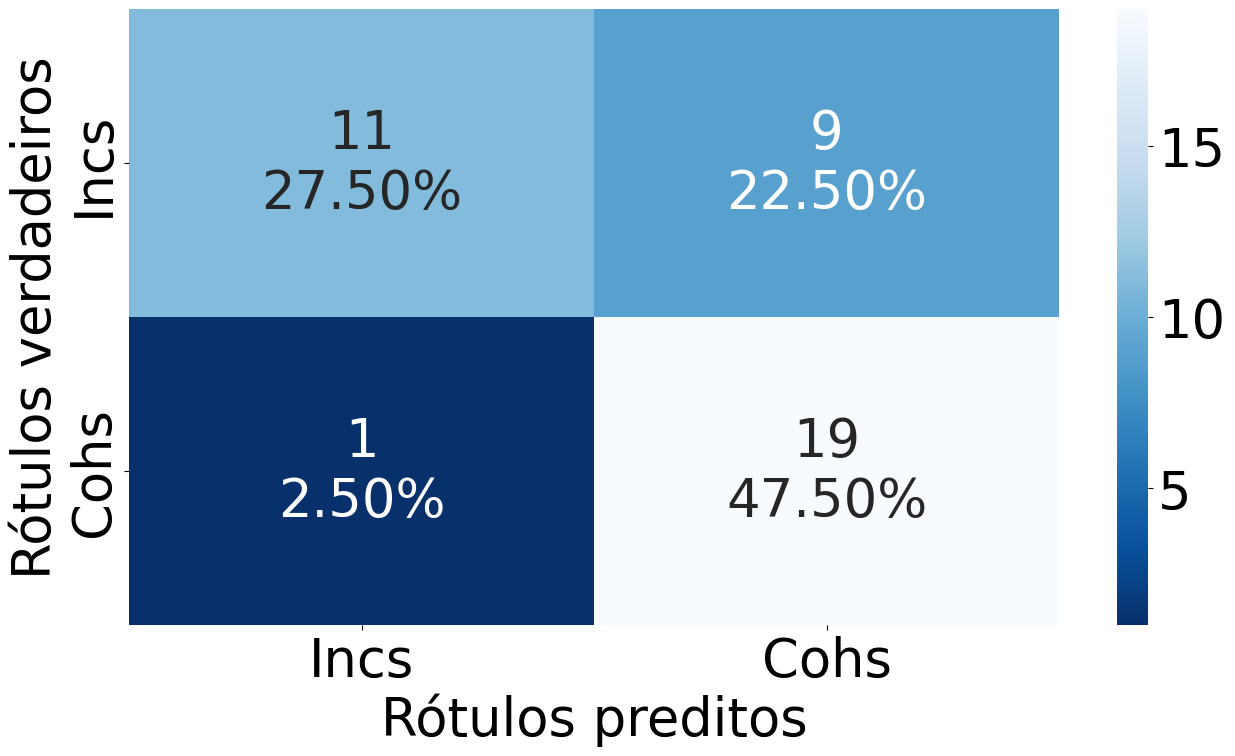

In [126]:
# Import das bibliotecas.
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

x_alvo =     df_dados_classificacao['classe'].tolist()
y_predicao = df_dados_classificacao['predicao'].tolist()

print(classification_report(x_alvo, y_predicao))

# Insere os dados no gráfico
cf_matrix = confusion_matrix(x_alvo, y_predicao)
quantidade_grupos = ["{0:0.0f}".format(valor) for valor in cf_matrix.flatten()]
percentual_grupos = ["{0:.2%}".format(valor) for valor in cf_matrix.flatten()/np.sum(cf_matrix)]
rotulos = [f"{v1}\n{v2}" for v1, v2 in zip(quantidade_grupos,percentual_grupos)]
rotulos = np.asarray(rotulos).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=rotulos, fmt='', cmap='Blues_r')

# Texto do eixo x
ax.set_xlabel('Rótulos preditos')
# Texto do eixo y
ax.set_ylabel('Rótulos verdadeiros')
# Rótulos adicionais
ax.xaxis.set_ticklabels(['Incs','Cohs'])
ax.yaxis.set_ticklabels(['Incs','Cohs'])

# Mostra o gráfico
plt.show()

### Listas em pares

#### Listas de pares de documentos originais e perturbados classificados corretamente

In [127]:
def listaClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
    # 0 - Documento perturbado
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])

  tipos = {"id": str}
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"])
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [128]:
lista_retorno_classificado_corretamente, lista_retorno_DO_correto, lista_retorno_pertDO_correto = listaClassificadoCorretamente(df_dados_classificacao)
print('Cohs e Incs classificados corretamente:', len(lista_retorno_classificado_corretamente))
print('Cohs classificados corretamente(VP)     :', len(lista_retorno_DO_correto))
print('Incs classificados corretamente(FP) :', len(lista_retorno_pertDO_correto))

Cohs e Incs classificados corretamente: 30
Cohs classificados corretamente(VP)     : 19
Incs classificados corretamente(FP) : 11


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [129]:
def listaClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
    # 0 - Documento Perturbado
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])

  tipos = {"id": str}
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"])
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [130]:
lista_retorno_classificado_incorretamente, lista_retorno_DO_incorreto, lista_retorno_pertDO_incorreto = listaClassificadoIncorretamente(df_dados_classificacao)
print('DO e pertDO classificados incorretamente:', len(lista_retorno_classificado_incorretamente))
print('DO classificados incorretamente(VN)     :', len(lista_retorno_DO_incorreto))
print('pertDO classificados incorretamente(FN) :', len(lista_retorno_pertDO_incorreto))

DO e pertDO classificados incorretamente: 10
DO classificados incorretamente(VN)     : 1
pertDO classificados incorretamente(FN) : 9


#### Acurácia das listas

In [131]:
total = len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente)
print("Total de documentos                 :", total)
print("  Total de documentos originais     :", (len(lista_retorno_DO_correto)+len(lista_retorno_DO_incorreto)))
print("  Total de documentos perturbados   :", (len(lista_retorno_pertDO_correto)+len(lista_retorno_pertDO_incorreto)))
print("Total de acertos                    :", len(lista_retorno_classificado_corretamente))
print("Total de erros                      :", len(lista_retorno_classificado_incorretamente))
print()
print("Acurácia                                        : {0:.2%}".format(len(lista_retorno_classificado_corretamente)/total))
print("  Cohs coerentes       = Verdadeiros positivos(VP): {0:.2%}".format(len(lista_retorno_DO_correto)/total))
print("  Incs incoerentes     = Falsos positivos(FP)     : {0:.2%}".format(len(lista_retorno_pertDO_correto)/total))
print("  Cohs incoerentes     = Verdadeiro negativos(VN) : {0:.2%}".format(len(lista_retorno_DO_incorreto)/total))
print("  Incs coerentes       = Falsos negativos(FN)     : {0:.2%}".format(len(lista_retorno_pertDO_incorreto)/total))

Total de documentos                 : 40
  Total de documentos originais     : 20
  Total de documentos perturbados   : 20
Total de acertos                    : 30
Total de erros                      : 10

Acurácia                                        : 75.00%
  Cohs coerentes       = Verdadeiros positivos(VP): 47.50%
  Incs incoerentes     = Falsos positivos(FP)     : 27.50%
  Cohs incoerentes     = Verdadeiro negativos(VN) : 2.50%
  Incs coerentes       = Falsos negativos(FN)     : 22.50%


#### Listas documentos originais e perturbados e suas classificações sem repetições

Remove a duplicidade dos documentos originais classificados corretamente(VP)

In [132]:
print("Com repetição:",len(lista_retorno_DO_correto))
lista_retorno_DO_classificado_corretamente_sem_repeticao = lista_retorno_DO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_corretamente_sem_repeticao))

Com repetição: 19
Sem repetição: 19


Criando dados indexados

In [133]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1


Remove a duplicidade dos documentos originais classificados incorretamente(VN)

In [134]:
print("Com repetição:",len(lista_retorno_DO_incorreto))
lista_retorno_DO_classificado_incorretamente_sem_repeticao = lista_retorno_DO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_incorretamente_sem_repeticao))

Com repetição: 1
Sem repetição: 1


Criando dados indexados

In [135]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
12,1,0


Remove a duplicidade dos documentos perturbados classificados corretamente(FP)

In [136]:
print("Com repetição:",len(lista_retorno_pertDO_correto))
lista_retorno_pertDO_classificado_corretamente_sem_repeticao = lista_retorno_pertDO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_corretamente_sem_repeticao))

Com repetição: 11
Sem repetição: 11


Criando dados indexados

In [137]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
7_pert_0,0,0
8_pert_0,0,0
9_pert_0,0,0
11_pert_0,0,0
12_pert_0,0,0


Remove a duplicidade dos documentos perturbados classificados incorretamente(FN)

In [138]:
print("Com repetição:",len(lista_retorno_pertDO_incorreto))
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao = lista_retorno_pertDO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_incorretamente_sem_repeticao))

Com repetição: 9
Sem repetição: 9


Criando dados indexados

In [139]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1_pert_0,0,1
2_pert_0,0,1
3_pert_0,0,1
4_pert_0,0,1
5_pert_0,0,1


Remove as duplicidades dos documentos classificados corretamente.

In [140]:
print("Com repetição:",len(lista_retorno_classificado_corretamente))
lista_retorno_classificado_corretamente_sem_repeticao = lista_retorno_classificado_corretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_corretamente_sem_repeticao))

Com repetição: 30
Sem repetição: 30


Criando dados indexados

In [141]:
lista_retorno_classificado_corretamente_sem_repeticao.sample(5)

,id,classe,predicao
15,12_pert_0,0,0
7,7_pert_0,0,0
29,20_pert_0,0,0
4,5,1,1
2,3,1,1


In [142]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_corretamente_sem_repeticao_indexado = lista_retorno_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1


Remove as duplicidades dos documentos perturbados classificados incorretamente.

In [143]:
print("Com repetição:",len(lista_retorno_classificado_incorretamente))
lista_retorno_classificado_incorretamente_sem_repeticao = lista_retorno_classificado_incorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_incorretamente_sem_repeticao))

Com repetição: 10
Sem repetição: 10


Criando dados indexados

In [144]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1_pert_0,0,1
2_pert_0,0,1
3_pert_0,0,1
4_pert_0,0,1
5_pert_0,0,1


### Listas

#### Lista de documentos originais(1) classificados corretamente(1)

In [145]:
def listaOriginalClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [146]:
lista_documento_original_classificado_corretamente = listaOriginalClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_original_classificado_corretamente:', len(lista_documento_original_classificado_corretamente))

lista_documento_original_classificado_corretamente: 19


In [147]:
print("Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1):", len(lista_documento_original_classificado_corretamente))
for i, documento in lista_documento_original_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1): 19
   0 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   1 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   2 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   3 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   4 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   5 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   6 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   7 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   8 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   9 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   10 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   11 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   12 - Em uma 

#### Lista de documento originais(1) classificados incorretamente(0)

In [148]:
def listaOriginalClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [149]:
lista_documento_original_classificado_incorretamente = listaOriginalClassificadoIncorretamente(df_dados_classificacao)

print("Lista de documentos originais classificados incorretamente:",len(lista_documento_original_classificado_incorretamente))

Lista de documentos originais classificados incorretamente: 1


In [150]:
print("Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0):", len(lista_documento_original_classificado_incorretamente))
for i, documento in lista_documento_original_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0): 1
   0 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1


#### Lista Documentos Perturbados(0) Classificados corretamente(0)

In [151]:
def listaPerturbadoClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [152]:
lista_documento_perturbado_classificado_corretamente = listaPerturbadoClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_corretamente:', len(lista_documento_perturbado_classificado_corretamente))

lista_documento_perturbado_classificado_corretamente: 11


In [153]:
print("Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0):", len(lista_documento_perturbado_classificado_corretamente))
for i, documento in lista_documento_perturbado_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0): 11
   0 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   1 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   2 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   3 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   4 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   5 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   6 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   7 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   8 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   9 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   10 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1


#### Lista Documentos Perturbados(0) Classificados incorretamente(1)

In [154]:
def listaPerturbadoClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [155]:
lista_documento_perturbado_classificado_incorretamente = listaPerturbadoClassificadoIncorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_incorretamente:', len(lista_documento_perturbado_classificado_incorretamente))

lista_documento_perturbado_classificado_incorretamente: 9


In [156]:
print("Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1):", len(lista_documento_perturbado_classificado_incorretamente))
for i, documento in lista_documento_perturbado_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1): 9
   0 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   1 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   2 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   3 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   4 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   5 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   6 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   7 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   8 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1


## 4.5 Carrega os dados da classificação Gemini

In [157]:
# Import das bibliotecas.
import pandas as pd
import io

def getDadosClassificacao():

  # Llama3 70B en
  dados = """id;classe;predicao
1;1;1
1_pert_0;0;0
2;1;1
2_pert_0;0;0
3;1;1
3_pert_0;0;0
4;1;1
4_pert_0;0;0
5;1;1
5_pert_0;0;0
6;1;1
6_pert_0;0;0
7;1;1
7_pert_0;0;0
8;1;1
8_pert_0;0;0
9;1;1
9_pert_0;0;0
10;1;1
10_pert_0;0;0
11;1;1
11_pert_0;0;0
12;1;1
12_pert_0;0;0
13;1;1
13_pert_0;0;0
14;1;1
14_pert_0;0;0
15;1;1
15_pert_0;0;0
16;1;1
16_pert_0;0;0
17;1;1
17_pert_0;0;0
18;1;1
18_pert_0;0;0
19;1;1
19_pert_0;0;0
20;1;1
20_pert_0;0;0"""

  # Lê a string como um DataFrame
  df_dados_classificacao = pd.read_csv(io.StringIO(dados), sep=";")

    # Corrige os tipos dos dados
  tipos = {"id": str}
  df_dados_classificacao = df_dados_classificacao.astype(tipos)

  print('Registros:', len(df_dados_classificacao))

  return df_dados_classificacao

In [158]:
# Recupera os dados da melhor classificação
df_dados_classificacao = getDadosClassificacao()

# Exibe o DataFrame
print(df_dados_classificacao)

Registros: 40
           id  classe  predicao
0           1       1         1
1    1_pert_0       0         0
2           2       1         1
3    2_pert_0       0         0
4           3       1         1
5    3_pert_0       0         0
6           4       1         1
7    4_pert_0       0         0
8           5       1         1
9    5_pert_0       0         0
10          6       1         1
11   6_pert_0       0         0
12          7       1         1
13   7_pert_0       0         0
14          8       1         1
15   8_pert_0       0         0
16          9       1         1
17   9_pert_0       0         0
18         10       1         1
19  10_pert_0       0         0
20         11       1         1
21  11_pert_0       0         0
22         12       1         1
23  12_pert_0       0         0
24         13       1         1
25  13_pert_0       0         0
26         14       1         1
27  14_pert_0       0         0
28         15       1         1
29  15_pert_0       0     

In [159]:
df_dados_classificacao.sample(5)

,id,classe,predicao
2,2,1,1
30,16,1,1
19,10_pert_0,0,0
18,10,1,1
15,8_pert_0,0,0


### Acurácia

In [160]:
def calculoClassificacao(df_dados_classificacao):
  vp_s = 0
  vn_s = 0
  fp_s = 0
  fn_s = 0
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    if linha['classe'] == 1 and linha['predicao'] == 1:
        vp_s = vp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 0:
        vn_s = vn_s + 1
    if linha['classe'] == 1 and linha['predicao'] == 0:
        fp_s = fp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 1:
        fn_s = fn_s + 1

  # Acurácia indica uma performance geral do modelo.
  # Dentre todas as classificações, quantas o modelo classificou corretamente(vp=1 e vn=0).
  if (vp_s+vn_s+fp_s+fn_s) != 0:
    acc = (vp_s+vn_s)/(vp_s+vn_s+fp_s+fn_s)
  else:
    acc  = 0

  # Recall(Revocação) avalia todas as situações da classe Positivo(vp=1) com o valor esperado e quantas estão corretas.
  if (vp_s+fn_s) != 0:
      rec = (vp_s)/(vp_s+fn_s)
  else:
      rec = 0

  # Precisão avalia as classificações da classe positivo(vp=1 e fp=0) que o modelo fez e quantas estão corretas.
  if (vp_s+fp_s) != 0:
      pre = (vp_s)/(vp_s+fp_s)
  else:
      pre = 0

  # F1 é a média harmônica entre precisão e recall.
  if (pre + rec) != 0:
    f1 = 2 * ((pre * rec)/(pre + rec))
  else:
    f1 = 0

  return acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s

In [161]:
acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s = calculoClassificacao(df_dados_classificacao)

print("Acurácia: {0:.2%}".format(acc))
print("Recall  : {0:.2%}".format(rec))
print("Precisão: {0:.2%}".format(pre))
print("F1      : {0:.2%}".format(f1))

total = vp_s + vn_s + fp_s + fn_s
print("Total   :", total)
print("vp      : {0:.2%} de {1:1d}".format((vp_s/total), vp_s))
print("vn      : {0:.2%} de {1:1d}".format((vn_s/total), vn_s))
print("fp      : {0:.2%} de {1:1d}".format((fp_s/total), fp_s))
print("fn      : {0:.2%} de {1:1d}".format((fn_s/total), fn_s))

Acurácia: 100.00%
Recall  : 100.00%
Precisão: 100.00%
F1      : 100.00%
Total   : 40
vp      : 50.00% de 20
vn      : 50.00% de 20
fp      : 0.00% de 0
fn      : 0.00% de 0


#### Matriz de confusão

In [162]:
# Import das bibliotecas.
import matplotlib
import matplotlib.pyplot as plt

TAMANHO_FONTE = 38
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE+2)   # Tamanho da fonte do título da figura

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



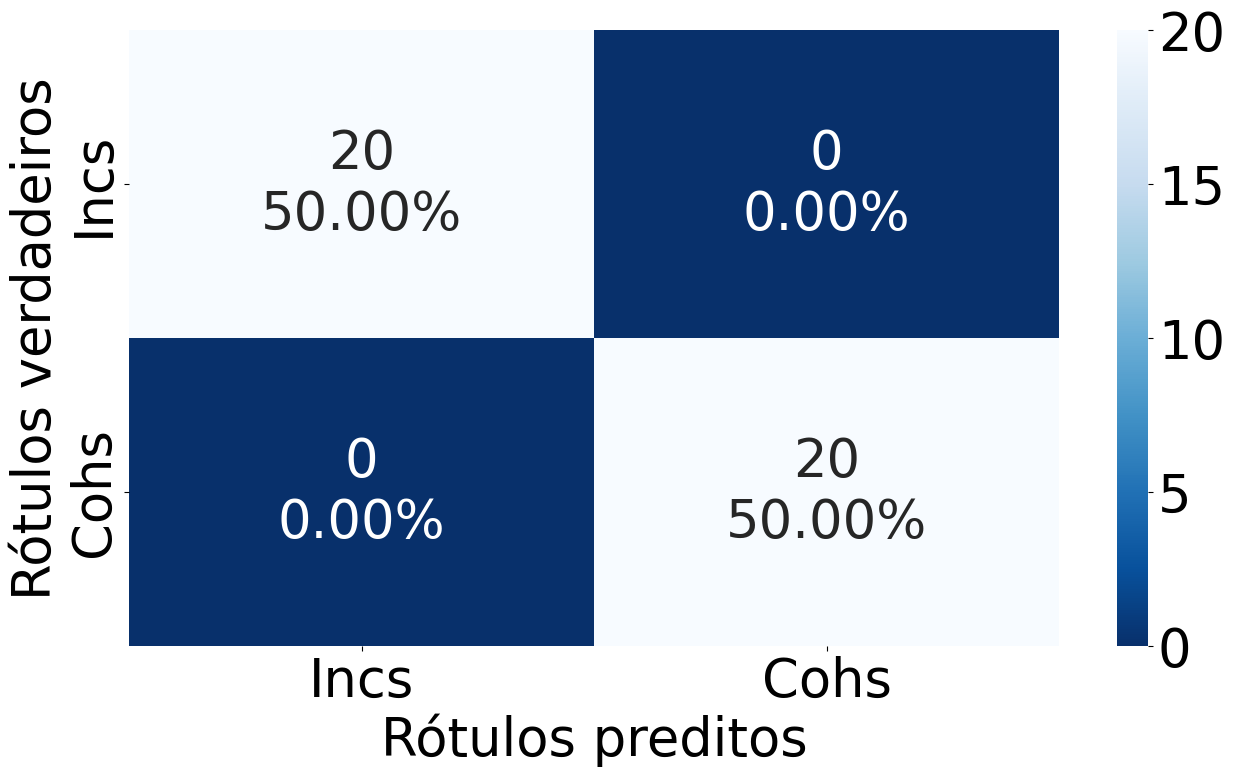

In [163]:
# Import das bibliotecas.
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

x_alvo =     df_dados_classificacao['classe'].tolist()
y_predicao = df_dados_classificacao['predicao'].tolist()

print(classification_report(x_alvo, y_predicao))

# Insere os dados no gráfico
cf_matrix = confusion_matrix(x_alvo, y_predicao)
quantidade_grupos = ["{0:0.0f}".format(valor) for valor in cf_matrix.flatten()]
percentual_grupos = ["{0:.2%}".format(valor) for valor in cf_matrix.flatten()/np.sum(cf_matrix)]
rotulos = [f"{v1}\n{v2}" for v1, v2 in zip(quantidade_grupos,percentual_grupos)]
rotulos = np.asarray(rotulos).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=rotulos, fmt='', cmap='Blues_r')

# Texto do eixo x
ax.set_xlabel('Rótulos preditos')
# Texto do eixo y
ax.set_ylabel('Rótulos verdadeiros')
# Rótulos adicionais
ax.xaxis.set_ticklabels(['Incs','Cohs'])
ax.yaxis.set_ticklabels(['Incs','Cohs'])

# Mostra o gráfico
plt.show()

### Listas em pares

#### Listas de pares de documentos originais e perturbados classificados corretamente

In [164]:
def listaClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
    # 0 - Documento perturbado
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])

  tipos = {"id": str}
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"])
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [165]:
lista_retorno_classificado_corretamente, lista_retorno_DO_correto, lista_retorno_pertDO_correto = listaClassificadoCorretamente(df_dados_classificacao)
print('Cohs e Incs classificados corretamente:', len(lista_retorno_classificado_corretamente))
print('Cohs classificados corretamente(VP)     :', len(lista_retorno_DO_correto))
print('Incs classificados corretamente(FP) :', len(lista_retorno_pertDO_correto))

Cohs e Incs classificados corretamente: 40
Cohs classificados corretamente(VP)     : 20
Incs classificados corretamente(FP) : 20


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [166]:
def listaClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
    # 0 - Documento Perturbado
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])

  tipos = {"id": str}
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"])
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [167]:
lista_retorno_classificado_incorretamente, lista_retorno_DO_incorreto, lista_retorno_pertDO_incorreto = listaClassificadoIncorretamente(df_dados_classificacao)
print('DO e pertDO classificados incorretamente:', len(lista_retorno_classificado_incorretamente))
print('DO classificados incorretamente(VN)     :', len(lista_retorno_DO_incorreto))
print('pertDO classificados incorretamente(FN) :', len(lista_retorno_pertDO_incorreto))

DO e pertDO classificados incorretamente: 0
DO classificados incorretamente(VN)     : 0
pertDO classificados incorretamente(FN) : 0


#### Acurácia das listas

In [168]:
total = len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente)
print("Total de documentos                 :", total)
print("  Total de documentos originais     :", (len(lista_retorno_DO_correto)+len(lista_retorno_DO_incorreto)))
print("  Total de documentos perturbados   :", (len(lista_retorno_pertDO_correto)+len(lista_retorno_pertDO_incorreto)))
print("Total de acertos                    :", len(lista_retorno_classificado_corretamente))
print("Total de erros                      :", len(lista_retorno_classificado_incorretamente))
print()
print("Acurácia                                        : {0:.2%}".format(len(lista_retorno_classificado_corretamente)/total))
print("  Cohs coerentes       = Verdadeiros positivos(VP): {0:.2%}".format(len(lista_retorno_DO_correto)/total))
print("  Incs incoerentes     = Falsos positivos(FP)     : {0:.2%}".format(len(lista_retorno_pertDO_correto)/total))
print("  Cohs incoerentes     = Verdadeiro negativos(VN) : {0:.2%}".format(len(lista_retorno_DO_incorreto)/total))
print("  Incs coerentes       = Falsos negativos(FN)     : {0:.2%}".format(len(lista_retorno_pertDO_incorreto)/total))

Total de documentos                 : 40
  Total de documentos originais     : 20
  Total de documentos perturbados   : 20
Total de acertos                    : 40
Total de erros                      : 0

Acurácia                                        : 100.00%
  Cohs coerentes       = Verdadeiros positivos(VP): 50.00%
  Incs incoerentes     = Falsos positivos(FP)     : 50.00%
  Cohs incoerentes     = Verdadeiro negativos(VN) : 0.00%
  Incs coerentes       = Falsos negativos(FN)     : 0.00%


#### Listas documentos originais e perturbados e suas classificações sem repetições

Remove a duplicidade dos documentos originais classificados corretamente(VP)

In [169]:
print("Com repetição:",len(lista_retorno_DO_correto))
lista_retorno_DO_classificado_corretamente_sem_repeticao = lista_retorno_DO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_corretamente_sem_repeticao))

Com repetição: 20
Sem repetição: 20


Criando dados indexados

In [170]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1


Remove a duplicidade dos documentos originais classificados incorretamente(VN)

In [171]:
print("Com repetição:",len(lista_retorno_DO_incorreto))
lista_retorno_DO_classificado_incorretamente_sem_repeticao = lista_retorno_DO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_incorretamente_sem_repeticao))

Com repetição: 0
Sem repetição: 0


Criando dados indexados

In [172]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,


Remove a duplicidade dos documentos perturbados classificados corretamente(FP)

In [173]:
print("Com repetição:",len(lista_retorno_pertDO_correto))
lista_retorno_pertDO_classificado_corretamente_sem_repeticao = lista_retorno_pertDO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_corretamente_sem_repeticao))

Com repetição: 20
Sem repetição: 20


Criando dados indexados

In [174]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1_pert_0,0,0
2_pert_0,0,0
3_pert_0,0,0
4_pert_0,0,0
5_pert_0,0,0


Remove a duplicidade dos documentos perturbados classificados incorretamente(FN)

In [175]:
print("Com repetição:",len(lista_retorno_pertDO_incorreto))
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao = lista_retorno_pertDO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_incorretamente_sem_repeticao))

Com repetição: 0
Sem repetição: 0


Criando dados indexados

In [176]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,


Remove as duplicidades dos documentos classificados corretamente.

In [177]:
print("Com repetição:",len(lista_retorno_classificado_corretamente))
lista_retorno_classificado_corretamente_sem_repeticao = lista_retorno_classificado_corretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_corretamente_sem_repeticao))

Com repetição: 40
Sem repetição: 40


Criando dados indexados

In [178]:
lista_retorno_classificado_corretamente_sem_repeticao.sample(5)

,id,classe,predicao
24,13,1,1
28,15,1,1
20,11,1,1
17,9_pert_0,0,0
38,20,1,1


In [179]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_corretamente_sem_repeticao_indexado = lista_retorno_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1,1,1
1_pert_0,0,0
2,1,1
2_pert_0,0,0
3,1,1


Remove as duplicidades dos documentos perturbados classificados incorretamente.

In [180]:
print("Com repetição:",len(lista_retorno_classificado_incorretamente))
lista_retorno_classificado_incorretamente_sem_repeticao = lista_retorno_classificado_incorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_incorretamente_sem_repeticao))

Com repetição: 0
Sem repetição: 0


Criando dados indexados

In [181]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,


### Listas

#### Lista de documentos originais(1) classificados corretamente(1)

In [182]:
def listaOriginalClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [183]:
lista_documento_original_classificado_corretamente = listaOriginalClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_original_classificado_corretamente:', len(lista_documento_original_classificado_corretamente))

lista_documento_original_classificado_corretamente: 20


In [184]:
print("Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1):", len(lista_documento_original_classificado_corretamente))
for i, documento in lista_documento_original_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1): 20
   0 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   1 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   2 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   3 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   4 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   5 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   6 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   7 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   8 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   9 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   10 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   11 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   12 - Em uma 

#### Lista de documento originais(1) classificados incorretamente(0)

In [185]:
def listaOriginalClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [186]:
lista_documento_original_classificado_incorretamente = listaOriginalClassificadoIncorretamente(df_dados_classificacao)

print("Lista de documentos originais classificados incorretamente:",len(lista_documento_original_classificado_incorretamente))

Lista de documentos originais classificados incorretamente: 0


In [187]:
print("Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0):", len(lista_documento_original_classificado_incorretamente))
for i, documento in lista_documento_original_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0): 0


#### Lista Documentos Perturbados(0) Classificados corretamente(0)

In [188]:
def listaPerturbadoClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [189]:
lista_documento_perturbado_classificado_corretamente = listaPerturbadoClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_corretamente:', len(lista_documento_perturbado_classificado_corretamente))

lista_documento_perturbado_classificado_corretamente: 20


In [190]:
print("Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0):", len(lista_documento_perturbado_classificado_corretamente))
for i, documento in lista_documento_perturbado_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0): 20
   0 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   1 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   2 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   3 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   4 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   5 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   6 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   7 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   8 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   9 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   10 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   11 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   12 - Em 

#### Lista Documentos Perturbados(0) Classificados incorretamente(1)

In [191]:
def listaPerturbadoClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [192]:
lista_documento_perturbado_classificado_incorretamente = listaPerturbadoClassificadoIncorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_incorretamente:', len(lista_documento_perturbado_classificado_incorretamente))

lista_documento_perturbado_classificado_incorretamente: 0


In [193]:
print("Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1):", len(lista_documento_perturbado_classificado_incorretamente))
for i, documento in lista_documento_perturbado_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1): 0


## 4.6 Carrega os dados da classificação Sabiá-3

In [194]:
# Import das bibliotecas.
import pandas as pd
import io

def getDadosClassificacao():

  # Llama3 70B en
  dados = """id;classe;predicao
1;1;1
1_pert_0;0;0
2;1;1
2_pert_0;0;0
3;1;1
3_pert_0;0;0
4;1;1
4_pert_0;0;0
5;1;1
5_pert_0;0;0
6;1;1
6_pert_0;0;0
7;1;1
7_pert_0;0;0
8;1;1
8_pert_0;0;0
9;1;1
9_pert_0;0;0
10;1;1
10_pert_0;0;0
11;1;1
11_pert_0;0;0
12;1;1
12_pert_0;0;0
13;1;1
13_pert_0;0;0
14;1;1
14_pert_0;0;0
15;1;1
15_pert_0;0;0
16;1;1
16_pert_0;0;0
17;1;1
17_pert_0;0;0
18;1;1
18_pert_0;0;0
19;1;1
19_pert_0;0;0
20;1;1
20_pert_0;0;0"""

  # Lê a string como um DataFrame
  df_dados_classificacao = pd.read_csv(io.StringIO(dados), sep=";")

    # Corrige os tipos dos dados
  tipos = {"id": str}
  df_dados_classificacao = df_dados_classificacao.astype(tipos)

  print('Registros:', len(df_dados_classificacao))

  return df_dados_classificacao

In [195]:
# Recupera os dados da melhor classificação
df_dados_classificacao = getDadosClassificacao()

# Exibe o DataFrame
print(df_dados_classificacao)

Registros: 40
           id  classe  predicao
0           1       1         1
1    1_pert_0       0         0
2           2       1         1
3    2_pert_0       0         0
4           3       1         1
5    3_pert_0       0         0
6           4       1         1
7    4_pert_0       0         0
8           5       1         1
9    5_pert_0       0         0
10          6       1         1
11   6_pert_0       0         0
12          7       1         1
13   7_pert_0       0         0
14          8       1         1
15   8_pert_0       0         0
16          9       1         1
17   9_pert_0       0         0
18         10       1         1
19  10_pert_0       0         0
20         11       1         1
21  11_pert_0       0         0
22         12       1         1
23  12_pert_0       0         0
24         13       1         1
25  13_pert_0       0         0
26         14       1         1
27  14_pert_0       0         0
28         15       1         1
29  15_pert_0       0     

In [196]:
df_dados_classificacao.sample(5)

,id,classe,predicao
21,11_pert_0,0,0
23,12_pert_0,0,0
16,9,1,1
27,14_pert_0,0,0
24,13,1,1


### Acurácia

In [197]:
def calculoClassificacao(df_dados_classificacao):
  vp_s = 0
  vn_s = 0
  fp_s = 0
  fn_s = 0
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    if linha['classe'] == 1 and linha['predicao'] == 1:
        vp_s = vp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 0:
        vn_s = vn_s + 1
    if linha['classe'] == 1 and linha['predicao'] == 0:
        fp_s = fp_s + 1
    if linha['classe'] == 0 and linha['predicao'] == 1:
        fn_s = fn_s + 1

  # Acurácia indica uma performance geral do modelo.
  # Dentre todas as classificações, quantas o modelo classificou corretamente(vp=1 e vn=0).
  if (vp_s+vn_s+fp_s+fn_s) != 0:
    acc = (vp_s+vn_s)/(vp_s+vn_s+fp_s+fn_s)
  else:
    acc  = 0

  # Recall(Revocação) avalia todas as situações da classe Positivo(vp=1) com o valor esperado e quantas estão corretas.
  if (vp_s+fn_s) != 0:
      rec = (vp_s)/(vp_s+fn_s)
  else:
      rec = 0

  # Precisão avalia as classificações da classe positivo(vp=1 e fp=0) que o modelo fez e quantas estão corretas.
  if (vp_s+fp_s) != 0:
      pre = (vp_s)/(vp_s+fp_s)
  else:
      pre = 0

  # F1 é a média harmônica entre precisão e recall.
  if (pre + rec) != 0:
    f1 = 2 * ((pre * rec)/(pre + rec))
  else:
    f1 = 0

  return acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s

In [198]:
acc, rec, pre, f1, vp_s, vn_s, fp_s, fn_s = calculoClassificacao(df_dados_classificacao)

print("Acurácia: {0:.2%}".format(acc))
print("Recall  : {0:.2%}".format(rec))
print("Precisão: {0:.2%}".format(pre))
print("F1      : {0:.2%}".format(f1))

total = vp_s + vn_s + fp_s + fn_s
print("Total   :", total)
print("vp      : {0:.2%} de {1:1d}".format((vp_s/total), vp_s))
print("vn      : {0:.2%} de {1:1d}".format((vn_s/total), vn_s))
print("fp      : {0:.2%} de {1:1d}".format((fp_s/total), fp_s))
print("fn      : {0:.2%} de {1:1d}".format((fn_s/total), fn_s))

Acurácia: 100.00%
Recall  : 100.00%
Precisão: 100.00%
F1      : 100.00%
Total   : 40
vp      : 50.00% de 20
vn      : 50.00% de 20
fp      : 0.00% de 0
fn      : 0.00% de 0


#### Matriz de confusão

In [199]:
# Import das bibliotecas.
import matplotlib
import matplotlib.pyplot as plt

TAMANHO_FONTE = 38
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE+2)   # Tamanho da fonte do título da figura

# Aumenta o tamanho da plotagem e o tamanho da fonte.
plt.rcParams['figure.figsize'] = (15,8)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



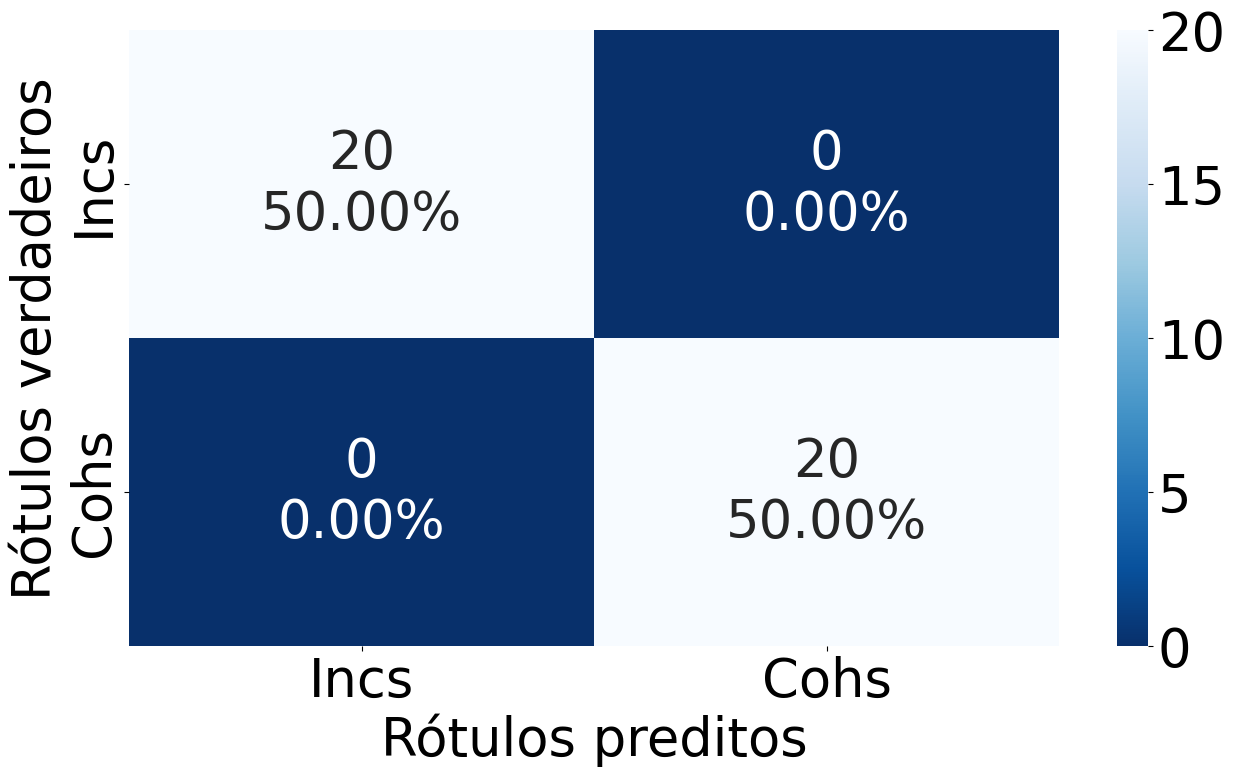

In [200]:
# Import das bibliotecas.
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

x_alvo =     df_dados_classificacao['classe'].tolist()
y_predicao = df_dados_classificacao['predicao'].tolist()

print(classification_report(x_alvo, y_predicao))

# Insere os dados no gráfico
cf_matrix = confusion_matrix(x_alvo, y_predicao)
quantidade_grupos = ["{0:0.0f}".format(valor) for valor in cf_matrix.flatten()]
percentual_grupos = ["{0:.2%}".format(valor) for valor in cf_matrix.flatten()/np.sum(cf_matrix)]
rotulos = [f"{v1}\n{v2}" for v1, v2 in zip(quantidade_grupos,percentual_grupos)]
rotulos = np.asarray(rotulos).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=rotulos, fmt='', cmap='Blues_r')

# Texto do eixo x
ax.set_xlabel('Rótulos preditos')
# Texto do eixo y
ax.set_ylabel('Rótulos verdadeiros')
# Rótulos adicionais
ax.xaxis.set_ticklabels(['Incs','Cohs'])
ax.yaxis.set_ticklabels(['Incs','Cohs'])

# Mostra o gráfico
plt.show()

### Listas em pares

#### Listas de pares de documentos originais e perturbados classificados corretamente

In [201]:
def listaClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    #if i < 20:
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
    # 0 - Documento perturbado
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])

  tipos = {"id": str}
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"])
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [202]:
lista_retorno_classificado_corretamente, lista_retorno_DO_correto, lista_retorno_pertDO_correto = listaClassificadoCorretamente(df_dados_classificacao)
print('Cohs e Incs classificados corretamente:', len(lista_retorno_classificado_corretamente))
print('Cohs classificados corretamente(VP)     :', len(lista_retorno_DO_correto))
print('Incs classificados corretamente(FP) :', len(lista_retorno_pertDO_correto))

Cohs e Incs classificados corretamente: 40
Cohs classificados corretamente(VP)     : 20
Incs classificados corretamente(FP) : 20


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [203]:
def listaClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  lista_retorno_DO = []
  lista_retorno_pertDO = []
  for i, linha in df_dados_classificacao.iterrows():
    # 1 - Documento Original
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno_DO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])
    # 0 - Documento Perturbado
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno_pertDO.append([linha['id'],linha['classe'],linha['predicao']])
        lista_retorno.append([linha['id'],linha['classe'],linha['predicao']])

  tipos = {"id": str}
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id","classe","predicao"])
  df_lista_retorno = df_lista_retorno.astype(tipos)

  df_lista_retorno_DO = pd.DataFrame(lista_retorno_DO, columns = ["id","classe","predicao"])
  df_lista_retorno_DO = df_lista_retorno_DO.astype(tipos)

  df_lista_retorno_pertDO = pd.DataFrame(lista_retorno_pertDO, columns = ["id","classe","predicao"])
  df_lista_retorno_pertDO = df_lista_retorno_pertDO.astype(tipos)

  return df_lista_retorno, df_lista_retorno_DO, df_lista_retorno_pertDO

In [204]:
lista_retorno_classificado_incorretamente, lista_retorno_DO_incorreto, lista_retorno_pertDO_incorreto = listaClassificadoIncorretamente(df_dados_classificacao)
print('DO e pertDO classificados incorretamente:', len(lista_retorno_classificado_incorretamente))
print('DO classificados incorretamente(VN)     :', len(lista_retorno_DO_incorreto))
print('pertDO classificados incorretamente(FN) :', len(lista_retorno_pertDO_incorreto))

DO e pertDO classificados incorretamente: 0
DO classificados incorretamente(VN)     : 0
pertDO classificados incorretamente(FN) : 0


#### Acurácia das listas

In [205]:
total = len(lista_retorno_classificado_corretamente) + len(lista_retorno_classificado_incorretamente)
print("Total de documentos                 :", total)
print("  Total de documentos originais     :", (len(lista_retorno_DO_correto)+len(lista_retorno_DO_incorreto)))
print("  Total de documentos perturbados   :", (len(lista_retorno_pertDO_correto)+len(lista_retorno_pertDO_incorreto)))
print("Total de acertos                    :", len(lista_retorno_classificado_corretamente))
print("Total de erros                      :", len(lista_retorno_classificado_incorretamente))
print()
print("Acurácia                                        : {0:.2%}".format(len(lista_retorno_classificado_corretamente)/total))
print("  Cohs coerentes       = Verdadeiros positivos(VP): {0:.2%}".format(len(lista_retorno_DO_correto)/total))
print("  Incs incoerentes     = Falsos positivos(FP)     : {0:.2%}".format(len(lista_retorno_pertDO_correto)/total))
print("  Cohs incoerentes     = Verdadeiro negativos(VN) : {0:.2%}".format(len(lista_retorno_DO_incorreto)/total))
print("  Incs coerentes       = Falsos negativos(FN)     : {0:.2%}".format(len(lista_retorno_pertDO_incorreto)/total))

Total de documentos                 : 40
  Total de documentos originais     : 20
  Total de documentos perturbados   : 20
Total de acertos                    : 40
Total de erros                      : 0

Acurácia                                        : 100.00%
  Cohs coerentes       = Verdadeiros positivos(VP): 50.00%
  Incs incoerentes     = Falsos positivos(FP)     : 50.00%
  Cohs incoerentes     = Verdadeiro negativos(VN) : 0.00%
  Incs coerentes       = Falsos negativos(FN)     : 0.00%


#### Listas documentos originais e perturbados e suas classificações sem repetições

Remove a duplicidade dos documentos originais classificados corretamente(VP)

In [206]:
print("Com repetição:",len(lista_retorno_DO_correto))
lista_retorno_DO_classificado_corretamente_sem_repeticao = lista_retorno_DO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_corretamente_sem_repeticao))

Com repetição: 20
Sem repetição: 20


Criando dados indexados

In [207]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1


Remove a duplicidade dos documentos originais classificados incorretamente(VN)

In [208]:
print("Com repetição:",len(lista_retorno_DO_incorreto))
lista_retorno_DO_classificado_incorretamente_sem_repeticao = lista_retorno_DO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_DO_classificado_incorretamente_sem_repeticao))

Com repetição: 0
Sem repetição: 0


Criando dados indexados

In [209]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_DO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_DO_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,


Remove a duplicidade dos documentos perturbados classificados corretamente(FP)

In [210]:
print("Com repetição:",len(lista_retorno_pertDO_correto))
lista_retorno_pertDO_classificado_corretamente_sem_repeticao = lista_retorno_pertDO_correto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_corretamente_sem_repeticao))

Com repetição: 20
Sem repetição: 20


Criando dados indexados

In [211]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1_pert_0,0,0
2_pert_0,0,0
3_pert_0,0,0
4_pert_0,0,0
5_pert_0,0,0


Remove a duplicidade dos documentos perturbados classificados incorretamente(FN)

In [212]:
print("Com repetição:",len(lista_retorno_pertDO_incorreto))
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao = lista_retorno_pertDO_incorreto.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_pertDO_classificado_incorretamente_sem_repeticao))

Com repetição: 0
Sem repetição: 0


Criando dados indexados

In [213]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_pertDO_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_pertDO_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,


Remove as duplicidades dos documentos classificados corretamente.

In [214]:
print("Com repetição:",len(lista_retorno_classificado_corretamente))
lista_retorno_classificado_corretamente_sem_repeticao = lista_retorno_classificado_corretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_corretamente_sem_repeticao))

Com repetição: 40
Sem repetição: 40


Criando dados indexados

In [215]:
lista_retorno_classificado_corretamente_sem_repeticao.sample(5)

,id,classe,predicao
20,11,1,1
24,13,1,1
30,16,1,1
9,5_pert_0,0,0
27,14_pert_0,0,0


In [216]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_corretamente_sem_repeticao_indexado = lista_retorno_classificado_corretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_corretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,
1,1,1
1_pert_0,0,0
2,1,1
2_pert_0,0,0
3,1,1


Remove as duplicidades dos documentos perturbados classificados incorretamente.

In [217]:
print("Com repetição:",len(lista_retorno_classificado_incorretamente))
lista_retorno_classificado_incorretamente_sem_repeticao = lista_retorno_classificado_incorretamente.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_classificado_incorretamente_sem_repeticao))

Com repetição: 0
Sem repetição: 0


Criando dados indexados

In [218]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_retorno_classificado_incorretamente_sem_repeticao_indexado = lista_retorno_classificado_incorretamente_sem_repeticao.set_index(["id"])
lista_retorno_classificado_incorretamente_sem_repeticao_indexado.head()

,classe,predicao
id,,


### Listas

#### Lista de documentos originais(1) classificados corretamente(1)

In [219]:
def listaOriginalClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [220]:
lista_documento_original_classificado_corretamente = listaOriginalClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_original_classificado_corretamente:', len(lista_documento_original_classificado_corretamente))

lista_documento_original_classificado_corretamente: 20


In [221]:
print("Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1):", len(lista_documento_original_classificado_corretamente))
for i, documento in lista_documento_original_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais classificados corretamente(coerentes)(classe=1 & previsão=1): 20
   0 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   1 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   2 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   3 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   4 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   5 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   6 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   7 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   8 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   9 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   10 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   11 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   12 - Em uma 

#### Lista de documento originais(1) classificados incorretamente(0)

In [222]:
def listaOriginalClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 1 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [223]:
lista_documento_original_classificado_incorretamente = listaOriginalClassificadoIncorretamente(df_dados_classificacao)

print("Lista de documentos originais classificados incorretamente:",len(lista_documento_original_classificado_incorretamente))

Lista de documentos originais classificados incorretamente: 0


In [224]:
print("Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0):", len(lista_documento_original_classificado_incorretamente))
for i, documento in lista_documento_original_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais classificados incorretamente(incoerentes)(classe=1 & previsão=0): 0


#### Lista Documentos Perturbados(0) Classificados corretamente(0)

In [225]:
def listaPerturbadoClassificadoCorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 0:
        lista_retorno.append(linha['id'])
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [226]:
lista_documento_perturbado_classificado_corretamente = listaPerturbadoClassificadoCorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_corretamente:', len(lista_documento_perturbado_classificado_corretamente))

lista_documento_perturbado_classificado_corretamente: 20


In [227]:
print("Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0):", len(lista_documento_perturbado_classificado_corretamente))
for i, documento in lista_documento_perturbado_classificado_corretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados classificados corretamente(incoerentes)(classe=0 & previsão=0): 20
   0 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   1 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   2 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   3 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   4 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   5 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   6 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   7 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   8 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   9 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   10 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   11 - Em uma fila a operação de enfileirar ocorre em qual extremidade? 1
   12 - Em 

#### Lista Documentos Perturbados(0) Classificados incorretamente(1)

In [228]:
def listaPerturbadoClassificadoIncorretamente(df_dados_classificacao):
  lista_retorno = []
  for i, linha in df_dados_classificacao.iterrows():
    if linha['classe'] == 0 and linha['predicao'] == 1:
        lista_retorno.append(linha['id'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])
  return df_lista_retorno

In [229]:
lista_documento_perturbado_classificado_incorretamente = listaPerturbadoClassificadoIncorretamente(df_dados_classificacao)
print('lista_documento_perturbado_classificado_incorretamente:', len(lista_documento_perturbado_classificado_incorretamente))

lista_documento_perturbado_classificado_incorretamente: 0


In [230]:
print("Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1):", len(lista_documento_perturbado_classificado_incorretamente))
for i, documento in lista_documento_perturbado_classificado_incorretamente.iterrows():
    # Recupera o documento a ser exibido
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados classificados incorretamente(coerente)(classe=0 & previsão=1): 0


# 5 Finalização

## 5.1 Tempo final de processamento



In [231]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))


  Tempo processamento:  0:01:40 (h:mm:ss)
